## 0.0. Init settings and libraries

In [1]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

%matplotlib inline
import matplotlib.pyplot as plt # библиотека визуализации
import seaborn as sns
# sns.set_style('whitegrid')
plt.style.use('ggplot')
sns.set(rc={'figure.figsize':(10, 8)})

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import HTML
HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
</style>
""")

import pandas as pd
import numpy as np
pd.set_option('display.float_format', '{:.2f}'.format)

## 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: `TabularAutoML` preset for AutoML model creation and Task class to setup what kind of ML problem we solve (binary/multiclass classification or regression)

In [2]:
# Standard python libraries
import os
import time


# Essential DS libraries
import category_encoders as ce
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

from comet_ml import Experiment
import Handlers as hd
import re

## 0.2. Fix package version

In [3]:
# !pip freeze > requirements.txt

## 0.3. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [4]:
# Base settings
RANDOM_STATE = 42
TEST_SIZE = 0.2
TARGET_FEATURE = 'reviewer_score'
SUBMISSION_FILE_NAME = 'submission_03.csv'

# LightAutoML settings
USE_LAML = False
N_THREADS = 4
N_FOLDS = 5
TIMEOUT = 30 * 60 # mins

# Comet_ML settings
USE_COMET_ML = False
COMET_PROJECT_NAME = 'Project3'

In [5]:
# Списки для добавления имен столбцов по ходу анализа для дальнейшей обработки
category_nominal_columns = set()
category_ordinal_columns = set()

## 0.4. Init Comet_ML

In [6]:
if USE_COMET_ML:
    experiment = Experiment(
        api_key="I1vM5jywyHjyrHOHaffYqCv6z",
        project_name=COMET_PROJECT_NAME,
        workspace="chepell",
    )

In [7]:
# Save text info about experiment on Comet_ML
if USE_COMET_ML:
    text = SUBMISSION_FILE_NAME + '\nГод в возраст и фильтрация по тьюки\n'
    text = text + 'Фильтрация милей по тьюки\n'
    text = text + 'Фильтрация целевого признака по логике и тьюки\n'

    experiment.log_text(text, step=None, metadata=None)

## 0.5. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [8]:
if USE_LAML:
    np.random.seed(RANDOM_STATE)
    torch.set_num_threads(N_THREADS)

## 0.6. Data loading
Let's check the data we have:

In [9]:
INPUT_DIR = 'data/'

In [10]:
train_data = pd.read_csv(INPUT_DIR + 'hotels_train.csv.zip')
print(train_data.shape)
train_data.head()

(386803, 17)


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.40,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.00,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.51,-0.14
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.30,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.30,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.52,-0.12
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.90,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.50,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.85,2.33
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.50,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.00,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.89,2.39
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.50,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.60,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.39,4.85


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [12]:
test_data = pd.read_csv(INPUT_DIR + 'hotels_test.csv.zip')
print(test_data.shape)
test_data.head()

(128935, 16)


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.10,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.53,9.17
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.60,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.39,4.83
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.30,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.39,2.16
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.10,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.48,9.20
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.10,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.37,4.89


In [13]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [14]:
submission = pd.read_csv(INPUT_DIR + 'submission.csv.zip')
print(submission.shape)
submission.head()

(128935, 2)


,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [15]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


## 0.7. Merge datasets

In [16]:
full_data = hd.merge_train_and_test_to_full(train_data, test_data, TARGET_FEATURE)
full_data.shape

(515738, 18)

## 0.8. Init visual analysis

In [17]:
# fig = plt.figure(figsize=(18, 12))
# pair = sns.pairplot(data=full_data.drop([TARGET_FEATURE], axis=1))

Обраить внимание на:\
lat - lng\
total_number_of_reviewers - additional_number_of_scoring

## 0.8. Cleaning Data

### Duplicates

In [18]:
duplicate_mask = full_data.duplicated()

In [19]:
# Всего дубликатов
duplicate_mask.sum()

336

In [20]:
# % дубликатов от всего датасета
duplicate_mask.mean() * 100

0.06514935878294793

In [21]:
# Можно добавить отдельный признак, что запись дубликат
# Но данный признак будет малоинформативным т.к. будет составлять 0.065% от всей выборки
# full_data['duplicate'] = duplicate_mask

In [22]:
# Сами дубликаты
duplicate_data = full_data[duplicate_mask]
duplicate_data


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,reviewer_score,dataset
21413,9 Rue Sainte Beuve 6th arr 75006 Paris France,22,9/27/2015,8.90,Hotel Le Sainte Beuve,Costa Rica,No Negative,0,143,Ir s a lovely boutique hotel full of Parisian...,53,4,"[' Leisure trip ', ' Family with older childre...",676 day,48.84,2.33,10.00,train
53110,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,44,9/25/2016,9.00,H tel Baume,Lebanon,nothing at all,4,253,bed was great staff are wonderful location ve...,10,1,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",312 day,48.85,2.34,10.00,train
54461,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,8/2/2016,7.90,H tel Concorde Montparnasse,Israel,The room to far from elevator,7,2515,Staff very nice and helpful Breakfast was per...,17,2,"[' Couple ', ' Classic Twin Room ', ' Stayed 3...",366 day,48.84,2.32,8.30,train
56542,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,44,7/2/2017,9.00,H tel Baume,Romania,Breakfast was a huge joke It was the worst po...,19,253,Room was great nice and spacious appartment f...,14,7,"[' Leisure trip ', ' Family with young childre...",32 days,48.85,2.34,7.90,train
65789,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,44,8/11/2015,9.00,H tel Baume,United Kingdom,No Negative,0,253,Friendly reception staff clean bathroom and l...,11,1,"[' Leisure trip ', ' Couple ', ' Superior Doub...",723 day,48.85,2.34,10.00,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499212,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,5/23/2016,7.90,H tel Concorde Montparnasse,United States of America,Nothing I will stay at this hotel again on my...,24,2515,The staff was very helpful and the property w...,21,8,"[' Leisure trip ', ' Family with older childre...",437 day,48.84,2.32,0.00,test
506924,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,2/1/2016,7.90,H tel Concorde Montparnasse,Malta,beautiful wiew,3,2515,cleanness staff very friendly very helpful,7,2,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",549 day,48.84,2.32,0.00,test
509781,167 rue de Rome 17th arr 75017 Paris France,11,12/12/2016,6.80,Villa Eugenie,Canada,Listed above,3,165,It was a terrible stat unfriendly staff very ...,13,1,"[' Business trip ', ' Solo traveler ', ' Stand...",234 day,48.89,2.31,0.00,test
512237,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,9/22/2015,7.90,H tel Concorde Montparnasse,Germany,Breakfast is pretty expensive however good,8,2515,Very good location good connections with Metr...,24,5,"[' Leisure trip ', ' Group ', ' Classic Twin R...",681 day,48.84,2.32,0.00,test


In [23]:
# Распределение дубликатов по выборкам
duplicate_data.groupby('dataset').agg({'hotel_name': 'count'})


,hotel_name
dataset,
test,29
train,307


In [24]:
train_dup_indexes = full_data[duplicate_mask & (full_data['dataset'] == 'train')].index

In [25]:
# Могу удалить дубликаты только с тренировочной выборки
full_data.drop(train_dup_indexes, inplace=True)

### Null and Empty features

In [26]:
# Меньше 1% отсутствующих значений и всего в двух признаках
hd.get_columns_isnull_info_df(full_data)

,feature,% of null
0,lat,0.63
1,lng,0.63


### Изучаю lat and lng

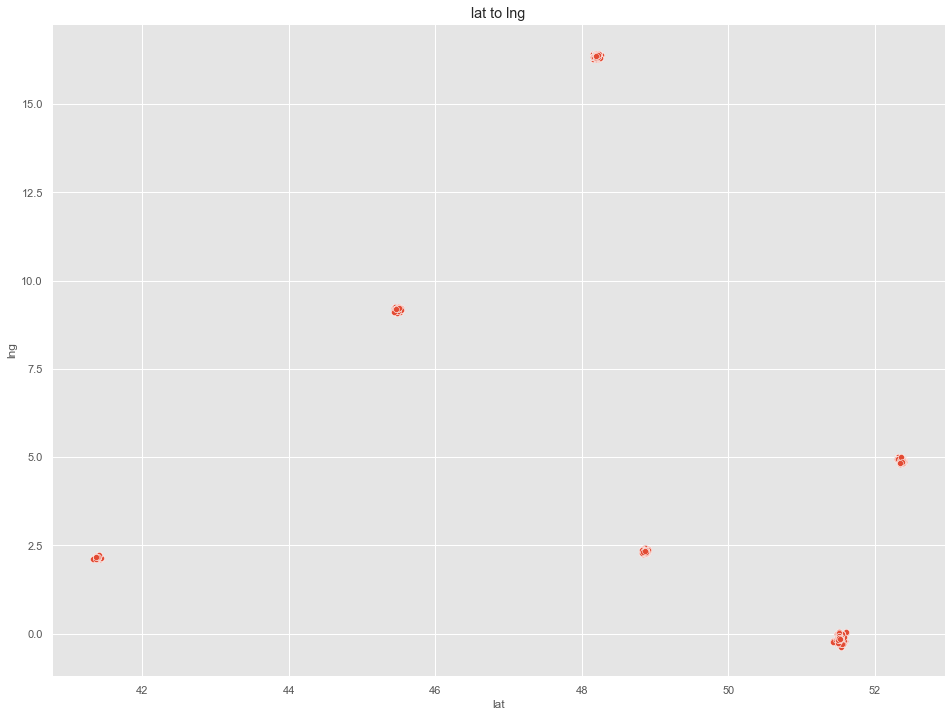

In [27]:
# Диаграмма рассеяния отлично показывает скопления координат. Фактически имеем 6 локаций где находятся отели
fig = plt.figure(figsize=(16, 12))
plot = sns.scatterplot(x=full_data['lat'], y=full_data['lng'])
plot.set_title('lat to lng')
fig.show()

In [28]:
# Заполняю пропуски по простому, медианой, это будет правое нижнее скопление
vals = {'lat': full_data['lat'].median(),
        'lng': full_data['lng'].median()}
full_data.fillna(value=vals, inplace=True)

## 1.0. EDA

### Анализ признаков
#### Если количество уникальных признаков (Count Unique < 150), то можно думать о переводе признака в категориальный

In [29]:
hd.get_top_unique_values(full_data)

,Column Name,Count Unique,% Unique,Top Value,Top Value Count,Top Value %
0,hotel_address,1493,0.29,163 Marsh Wall Docklands Tower Hamlets London ...,4789,0.93
1,additional_number_of_scoring,480,0.09,2682,4789,0.93
2,review_date,731,0.14,8/2/2017,2584,0.50
3,average_score,34,0.01,8.40,41222,8.00
4,hotel_name,1492,0.29,Britannia International Hotel Canary Wharf,4789,0.93
5,reviewer_nationality,227,0.04,United Kingdom,245165,47.57
6,negative_review,330011,64.03,No Negative,127816,24.80
7,review_total_negative_word_counts,402,0.08,0,127816,24.80
8,total_number_of_reviews,1142,0.22,9086,4789,0.93
9,positive_review,412601,80.05,No Positive,35924,6.97


average_score можно перевести в категориальный признак т.к. всего 34 уникальных значения

In [30]:
# Ишу малоинформативные признаки
hd.get_low_inform_features_list(full_data)

'Нет малоинформативных признаков!'

### EXPLORE: review_date

In [31]:
# Преобразую дату
full_data['review_date'] = pd.to_datetime(full_data['review_date'])

In [32]:
full_data['review_date'].describe()

count                  515431
unique                    731
top       2017-08-02 00:00:00
freq                     2584
first     2015-08-04 00:00:00
last      2017-08-03 00:00:00
Name: review_date, dtype: object

In [33]:
# Инетересен разброс. В самый активный день оставленно 2584 обзора, а в самый пассивный всего 142.
full_data['review_date'].value_counts()

2017-08-02    2584
2016-09-15    2304
2017-04-05    2284
2016-08-30    1959
2016-02-16    1939
              ... 
2016-09-10     199
2015-11-27     194
2017-04-03     192
2017-04-01     173
2017-04-02     142
Name: review_date, Length: 731, dtype: int64

### Дни недели

In [34]:
full_data['day_of_week'] = full_data['review_date'].dt.day_name()

In [35]:
# Меньше всего обзоров пишется в пт и сб, все хотят отдыхать 
# или как раз бронирут отели и едут на коротких отдых в пт веречером
full_data['day_of_week'].value_counts(True) * 100

Tuesday     23.45
Sunday      16.28
Monday      15.73
Thursday    14.44
Wednesday   11.36
Saturday    10.05
Friday       8.67
Name: day_of_week, dtype: float64

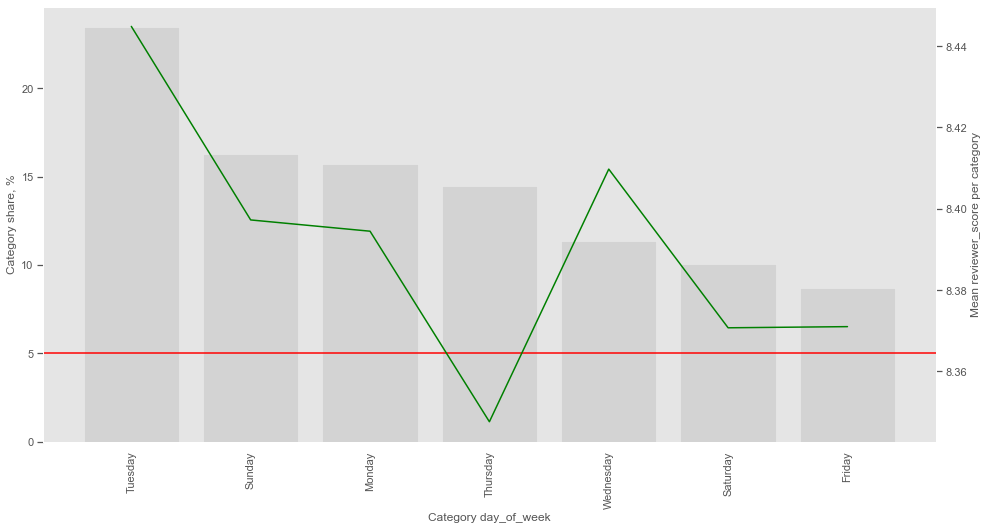

In [36]:
hd.plot_categories_and_targer(full_data, 'day_of_week', TARGET_FEATURE, func='mean', level=5)

In [37]:
# День недели - категориальный номинальный признак. преобразую
full_data['day_of_week'] = full_data['day_of_week'].astype('category')
# Добавляю в список имя для дальнейшей обработки
category_nominal_columns.add('day_of_week')

### Месяцы

In [38]:
full_data['month'] = full_data['review_date'].dt.month

In [39]:
# Наибольшая активность в августе, июле и мае.
full_data['month'].value_counts(True) * 100

8    9.82
7    9.56
5    9.02
10   8.50
6    8.32
4    8.32
9    8.22
1    8.17
3    7.97
12   7.68
2    7.44
11   6.97
Name: month, dtype: float64

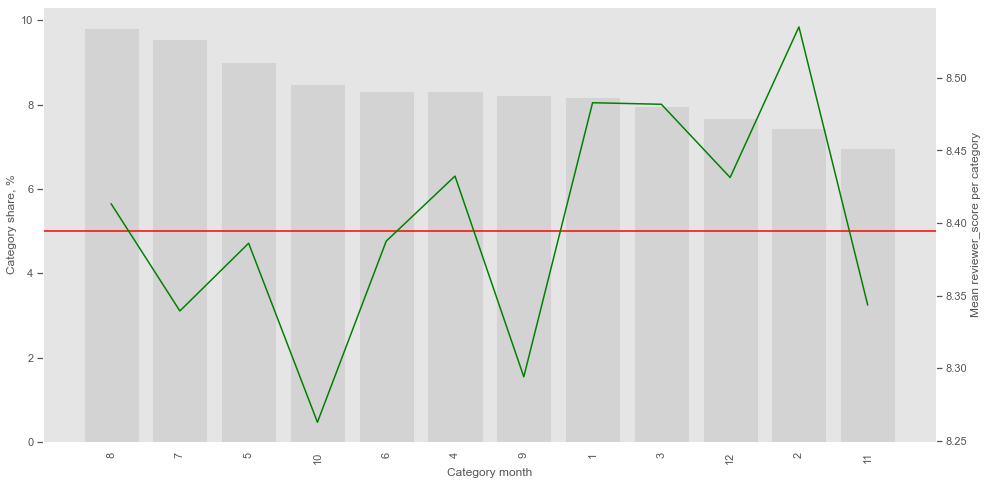

In [40]:
hd.plot_categories_and_targer(full_data, 'month', TARGET_FEATURE, func='mean', level=5)

In [41]:
# Добавляю имя
category_nominal_columns.add('month')

### Кварталы

In [42]:
full_data['quarter'] = full_data['review_date'].dt.quarter

In [43]:
full_data['quarter'].value_counts(True) * 100

3   27.61
2   25.65
1   23.59
4   23.15
Name: quarter, dtype: float64

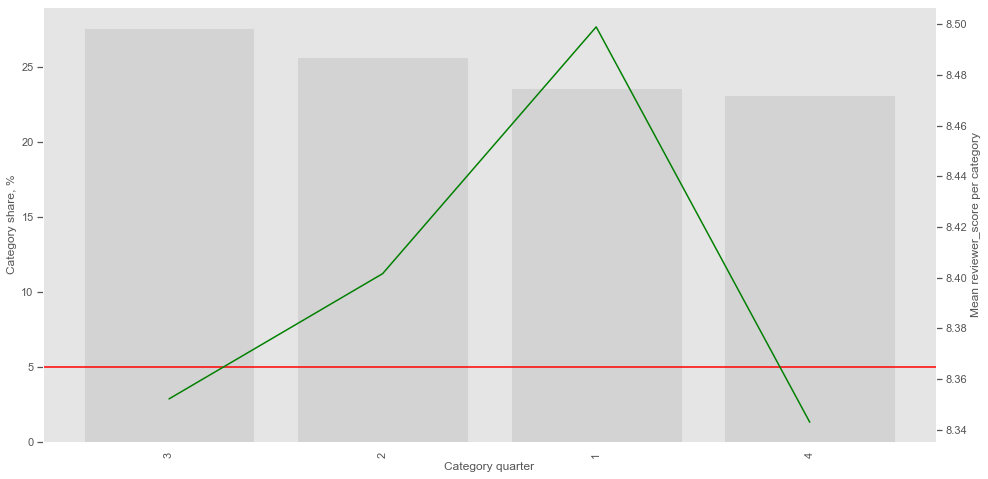

In [44]:
# Получается что в 3ем квартале пишут больше всего отчетов, но средний бал почти самый низкий, ниже только в 4ом квартале
hd.plot_categories_and_targer(full_data, 'quarter', TARGET_FEATURE, func='mean', level=5)

In [45]:
# Добавляю имя
category_nominal_columns.add('quarter')

### Ежедневная активность
Сколько обзоров всего было опубликовано в конкретный день

In [46]:
count_daily_review = full_data.groupby('review_date')['review_date'].agg(['count']).reset_index()
count_daily_review.rename(columns={'count': 'daily_activity'}, inplace=True)
count_daily_review

,review_date,daily_activity
0,2015-08-04,1346
1,2015-08-05,422
2,2015-08-06,797
3,2015-08-07,344
4,2015-08-08,573
...,...,...
726,2017-07-30,568
727,2017-07-31,729
728,2017-08-01,637
729,2017-08-02,2584


In [47]:
count_daily_review['daily_activity'].value_counts(True) * 100

427    0.68
593    0.68
581    0.55
363    0.55
531    0.55
       ... 
1030   0.14
305    0.14
813    0.14
448    0.14
855    0.14
Name: daily_activity, Length: 522, dtype: float64

In [48]:
count_daily_review['daily_activity'].describe()

count    731.00
mean     705.10
std      353.84
min      142.00
25%      466.50
50%      611.00
75%      824.00
max     2584.00
Name: daily_activity, dtype: float64

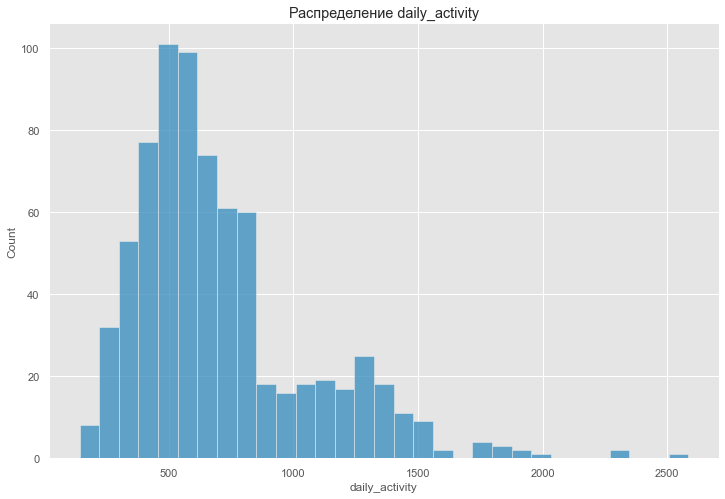

In [49]:
# Распределение количества отзывов за день похоже на нормальное, но со значительным правым хвостом
fig = plt.figure(figsize=(12, 8))
hist = sns.histplot(data=count_daily_review, x='daily_activity')
hist.set_title('Распределение daily_activity');

In [50]:
# добавляю столбец date_count_review в общий датасет
full_data = full_data.merge(count_daily_review, on='review_date', how='left')

Удаляю исходный признак review_date

In [51]:
full_data.drop('review_date', axis=1, inplace=True)

### EXPLORE: average_score

In [52]:
# Значения лежат в промежутке 5-10
full_data['average_score'].describe()

count   515431.00
mean         8.40
std          0.55
min          5.20
25%          8.10
50%          8.40
75%          8.80
max          9.80
Name: average_score, dtype: float64

In [53]:
full_data['average_score'].value_counts(True) * 100

8.40   8.00
8.10   7.40
8.50   7.39
8.70   7.33
8.60   7.17
8.20   6.76
8.30   6.38
8.80   5.98
8.90   5.53
8.00   4.33
9.10   4.15
9.00   4.07
7.80   3.86
7.90   2.91
7.50   2.66
9.20   2.51
9.30   2.46
7.70   2.29
9.40   1.81
7.10   1.32
7.60   1.30
7.40   1.22
7.30   0.78
7.00   0.76
6.90   0.34
6.80   0.26
9.50   0.23
6.40   0.23
6.70   0.19
9.60   0.18
7.20   0.13
6.60   0.08
5.20   0.01
9.80   0.01
Name: average_score, dtype: Float64

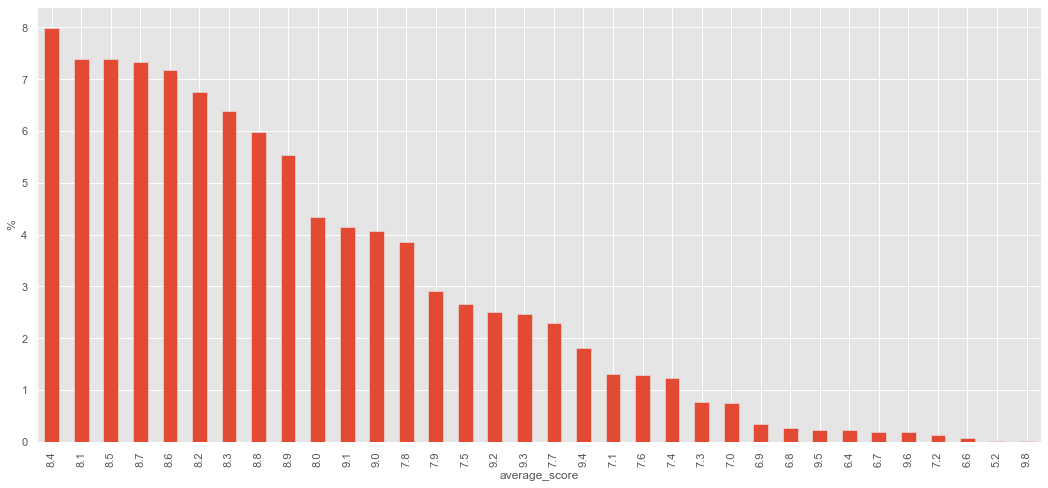

In [54]:
fig = plt.figure(figsize=(18, 8))
fig = (full_data['average_score'].value_counts(True) * 100).plot.bar()
fig.set_xlabel('average_score')
fig.set_ylabel('%');

In [55]:
# 34 уникальных значения
full_data['average_score'].nunique()

34

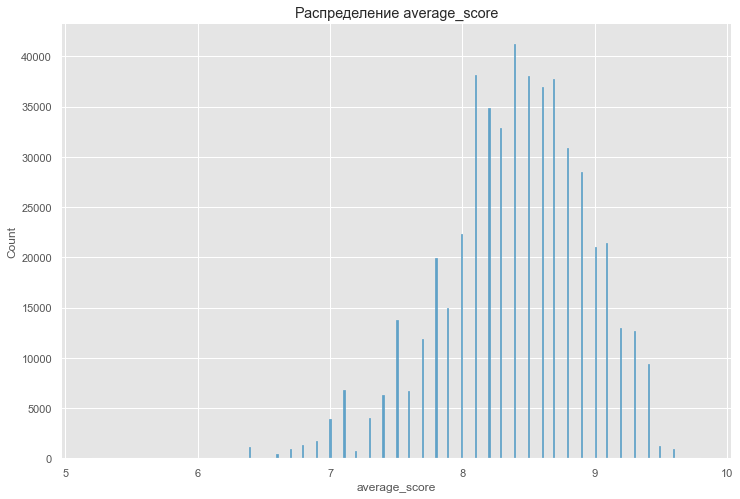

In [56]:
fig = plt.figure(figsize=(12, 8))
hist = sns.histplot(data=full_data, x='average_score')
hist.set_title('Распределение average_score');

Распределение признака похоже на нормальное

In [57]:
# hd.QQ_Plots(full_data, 'average_score')

### average_score, варианты разбиения на категории

In [58]:
# lab_list = ['5-5.5', '5.5-6', '6-6.5', '6.5-7', '7-7.5', '7.5-8', '8-8.5', '8.5-9', '9-9.5', '9.5-10']
# order_list = list(np.arange(5, 10.5, 0.5))
# order_list

# # Словарь для дальнейшей кодировки признака
# dict_for_ordinal = dict(zip(lab_list, order_list))

In [59]:
# full_data['average_score_cat'] = pd.cut(full_data['average_score'], bins=order_list, labels=lab_list, include_lowest=True)

In [60]:
# Размерность снижается до 10 категорий
# Категориальный порядковый признак
# full_data['average_score_cat'].value_counts(True) * 100

In [61]:
# hd.plot_categories_and_targer(full_data, 'average_score_cat', TARGET_FEATURE, func='mean', level=5)

In [62]:
# category_ordinal_columns.add('average_score_cat')

Исходный признак пока не удаляю

### EXPLORE: hotel_address

In [63]:
# Визуальный анализ адресов показывает, что в самом конце идет название страны, перед этим город.
# Название страны из одного слова, кроме случаев United Kingdom, тогда город на 5ом месте с конца.
# full_data['hotel_address'].to_list()

### Получения страны из адреса

In [64]:
def country_feature(hotel_address):
    hotel_address = str(hotel_address)
    
    address_lst = hotel_address.split()
    
    last_word = address_lst[-1]
    
    if last_word == 'Kingdom':
        return 'United Kingdom'
    
    return last_word

In [65]:
full_data['country'] = full_data['hotel_address'].apply(country_feature)

In [66]:
# Получается всего 6 стран, country
# 50% отелей приходится на Великобританию
full_data['country'].value_counts(True) * 100

United Kingdom   50.89
Spain            11.67
France           11.57
Netherlands      11.10
Austria           7.55
Italy             7.22
Name: country, dtype: float64

In [67]:
# Это категориальный номинальный признак. Преобразую
full_data['country'] = full_data['country'].astype('category')
category_nominal_columns.add('country')

### Получение города из адреса

In [68]:
def city_feature(hotel_address):
    hotel_address = str(hotel_address)
    
    address_lst = hotel_address.split()
    
    last_word = address_lst[-1]
    
    if last_word == 'Kingdom':
        return address_lst[-5]
    
    return address_lst[-2]

In [69]:
full_data['city'] = full_data['hotel_address'].apply(city_feature)

In [70]:
# Всего 6 городов, как и стран. Получается по городу в стране.
# Два эти признака полностью дублируют друг друга, но пока оставляю, ничего не удаляю.
# Сейчас идет генерация признаков, отбор и удаление будет позже.
full_data['city'].value_counts(True) * 100

London      50.89
Barcelona   11.67
Paris       11.57
Amsterdam   11.10
Vienna       7.55
Milan        7.22
Name: city, dtype: float64

Так же становится понятно, что 6 скоплений координат lat - lng соответствуют 6 городам.\
Т.е. инормация дублируется и к тому же в lat - lng были пропуски, которые заполнялись медианой, т.е. качество данных ну такое...\
От lat - lng нужно вообще избавиться, но это сделаю после изучения корерляции.

In [71]:
# Город это тоже категориальный номинальный признак
full_data['city'] = full_data['city'].astype('category')
category_nominal_columns.add('city')

### Внешние данные

In [72]:
# Информация по странам
countries_data = pd.read_csv('data\population_by_country_2020.zip')

In [73]:
# Оставляю только два признака, название страны и население
countries_data = countries_data.iloc[:, 0:2]
countries_data.columns = ['country', 'country_population']
countries_data

,country,country_population
0,China,1440297825
1,India,1382345085
2,United States,331341050
3,Indonesia,274021604
4,Pakistan,221612785
...,...,...
230,Montserrat,4993
231,Falkland Islands,3497
232,Niue,1628
233,Tokelau,1360


In [74]:
# Добавляю признак популяции в стране
full_data = full_data.merge(countries_data, on='country', how='left')

In [75]:
# После присоединения почему-то отваливается тип категории, восстанавливаю
full_data['country'] = full_data['country'].astype('category')

In [76]:
# Информация по городам
cities_data = pd.read_csv('data\worldcitiespop.zip')

In [77]:
cities_data = cities_data.iloc[:, [0, 1, 4]] # оставляю три признака
cities_data.columns = ['country_code', 'city', 'city_population'] # Переименовываю столбцы
cities_data['city'] = cities_data['city'].str.capitalize() # Город с большой буквы
cities_data = cities_data[cities_data['city_population'].notnull()] # Оставляю города где есть значение популяции
cities_data['city_population'] = cities_data['city_population'].astype('int') # Преобразую популяцию к целому числу, непонятно вообще почему тут был float
cities_data


,country_code,city,city_population
6,ad,Andorra la vella,20430
20,ad,Canillo,3292
32,ad,Encamp,11224
49,ad,La massana,7211
53,ad,Les escaldes,15854
...,...,...,...
3173646,zw,Redcliffe,38231
3173676,zw,Rusape,23761
3173737,zw,Shurugwi,17107
3173892,zw,Victoria falls,36702


In [78]:
country_codes = ['gb', 'es', 'fr', 'nl', 'at', 'it'] # коды стран в которых у нас есть отели
our_country_mask = cities_data['country_code'].apply(lambda x: x in country_codes) # маска для отбора только стран из списка выше

cities_data = cities_data[our_country_mask]
cities_data.drop('country_code', axis=1, inplace=True) # признак country_code больше не нужен
cities_data

,city,city_population
136102,Absam,6594
136111,Abtenau,5829
136311,Altach,6040
136379,Althofen,4833
136395,Altmunster,9652
...,...,...
2034331,Zuidhorn,18338
2034361,Zundert,20656
2034367,Zutphen,38399
2034416,Zwijndrecht,41148


In [79]:
# Добавляю признак популяции в городе
full_data = full_data.merge(cities_data, on=['city'], how='left')

In [80]:
# После присоединения почему-то отваливается тип категории, восстанавливаю
full_data['city'] = full_data['city'].astype('category')

In [81]:
# Доля города в населении всей страны в %, точность тут вряд ли важна, поэтому округляю и привожу к целому типу
full_data['share_of_country'] = (full_data['city_population'] / full_data['country_population'] * 100).round().astype('int')

In [82]:
full_data['share_of_country'].value_counts(True) * 100

11   50.89
3    23.24
4    11.10
17    7.55
2     7.22
Name: share_of_country, dtype: float64

### Столица
Могу получить дополнительный признак является ли город столицей

In [83]:
def is_capital_feature(city):
    # Складываю в список только столицы
    # Столица Италии - Рим, а не Милан
    # Столица Испании - Мадрид, а не Барселона
    capitals = ['London', 'Paris', 'Amsterdam', 'Vienna']
    
    if city in capitals:
        return True
    
    return False

In [84]:
full_data['is_capital'] = full_data['city'].apply(is_capital_feature)

In [85]:
# Это категориальный бинарный номинальный признак
category_nominal_columns.add('is_capital')

Признак hotel_address можно удалить, оттуда уже ничего больше вытаскивать не буду

In [86]:
full_data.drop('hotel_address', axis=1, inplace=True)

### EXPLORE: days_since_review

In [87]:
full_data['days_since_review'].describe()

count     515431
unique       731
top       1 days
freq        2584
Name: days_since_review, dtype: object

In [88]:
full_data['days_since_review'].unique()

<StringArray>
['531 day', '203 day', '289 day', '681 day', '516 day', '582 day', '77 days',
 '192 day', '618 day', '548 day',
 ...
 '251 day', '511 day', '125 day', '122 day', '477 day', '126 day', '701 day',
 '552 day', '257 day', '96 days']
Length: 731, dtype: string

In [89]:
# Функция для выделения из признака количества дней
def reformat_days_since_review(days_since_review):
    days_str = str(days_since_review)
    
    days = days_str.split()[0]
    
    return int(days)

In [90]:
full_data['days_since_review'] = full_data['days_since_review'].apply(reformat_days_since_review)

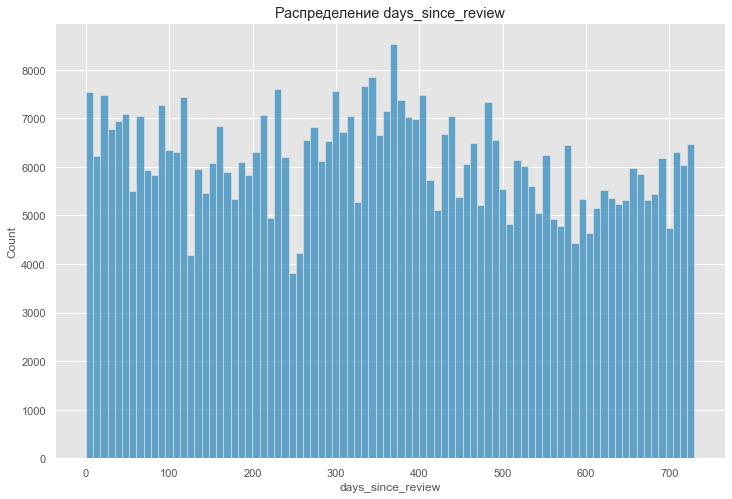

In [91]:
# Распределение похоже на забор, т.е. более-менее равномерно каждый день выставлялись оценки отелям
fig = plt.figure(figsize=(12, 8))
hist = sns.histplot(data=full_data, x='days_since_review')
hist.set_title('Распределение days_since_review');

### EXPLORE: reviewer_nationality

In [92]:
# Вижу лишние пробелы
full_data['reviewer_nationality'][0]

' United Kingdom '

In [93]:
# Удаляю лишние пробелы
full_data['reviewer_nationality'] = full_data['reviewer_nationality'].str.strip()

In [94]:
# Категориальный номинальный признак с огромным количеством уникальных категорий 227!
reviewer_nationality_counts = full_data['reviewer_nationality'].value_counts()
reviewer_nationality_counts

United Kingdom              245165
United States of America     35390
Australia                    21663
Ireland                      14820
United Arab Emirates         10230
                             ...  
Guinea                           1
Tuvalu                           1
Comoros                          1
Anguilla                         1
Cape Verde                       1
Name: reviewer_nationality, Length: 227, dtype: Int64

In [95]:
# Создаю бинарный признак, что ревьювер гражданин страны отелю которой он ставит оценку. Возможно к своим требования не такие как к чужим
full_data['is_reviewer_citizen'] = full_data['reviewer_nationality'] == full_data['country']

In [96]:
# 65% это постояльцы из других стран
full_data['is_reviewer_citizen'].value_counts(True) * 100

False   65.39
True    34.61
Name: is_reviewer_citizen, dtype: Float64

In [97]:
# Это категориальный номинальный бинарный признак
category_nominal_columns.add('is_reviewer_citizen')

In [98]:
# reviewer_nationality категориальный, номинальный признак
# Необходимо уменьшить число уникальных значений

# от 1000 отзывов конкретной национальности, тогда 55 категорий + все остальные
len(reviewer_nationality_counts[reviewer_nationality_counts > 1000])

55

In [99]:
# Топ 30 национальностей в % от всего количества отзывов
full_data['reviewer_nationality'].value_counts(True).nlargest(30) * 100

United Kingdom             47.57
United States of America    6.87
Australia                   4.20
Ireland                     2.88
United Arab Emirates        1.98
Saudi Arabia                1.74
Netherlands                 1.70
Switzerland                 1.68
Germany                     1.54
Canada                      1.53
France                      1.41
Israel                      1.28
Italy                       1.19
Belgium                     1.17
Turkey                      1.06
Kuwait                      0.95
Spain                       0.92
Romania                     0.88
Russia                      0.76
South Africa                0.74
India                       0.67
Greece                      0.66
China                       0.66
Sweden                      0.65
New Zealand                 0.63
Singapore                   0.60
Hong Kong                   0.58
Poland                      0.56
Qatar                       0.53
Austria                     0.47
Name: revi

In [100]:
# Кажется ниже 1% вообще нет смысла идти. Т.е. получается 15 категорий + все остальные.
top_15 = full_data['reviewer_nationality'].value_counts(True).nlargest(15) * 100
top_15_list = list(top_15.index)
top_15_list

['United Kingdom',
 'United States of America',
 'Australia',
 'Ireland',
 'United Arab Emirates',
 'Saudi Arabia',
 'Netherlands',
 'Switzerland',
 'Germany',
 'Canada',
 'France',
 'Israel',
 'Italy',
 'Belgium',
 'Turkey']

In [101]:
# Сокращаю количество категорий, оставляю те, которых хотя бы 1% есть в датасете
# full_data['reviewer_nationality'] = full_data['reviewer_nationality'].apply(lambda x: x if x in top_15_list else 'other')

full_data = hd.group_rare_labels(full_data, 'reviewer_nationality', level=1)

In [102]:
full_data['reviewer_nationality'].value_counts(True) * 100

United Kingdom             47.57
RARE                       22.21
United States of America    6.87
Australia                   4.20
Ireland                     2.88
United Arab Emirates        1.98
Saudi Arabia                1.74
Netherlands                 1.70
Switzerland                 1.68
Germany                     1.54
Canada                      1.53
France                      1.41
Israel                      1.28
Italy                       1.19
Belgium                     1.17
Turkey                      1.06
Name: reviewer_nationality, dtype: float64

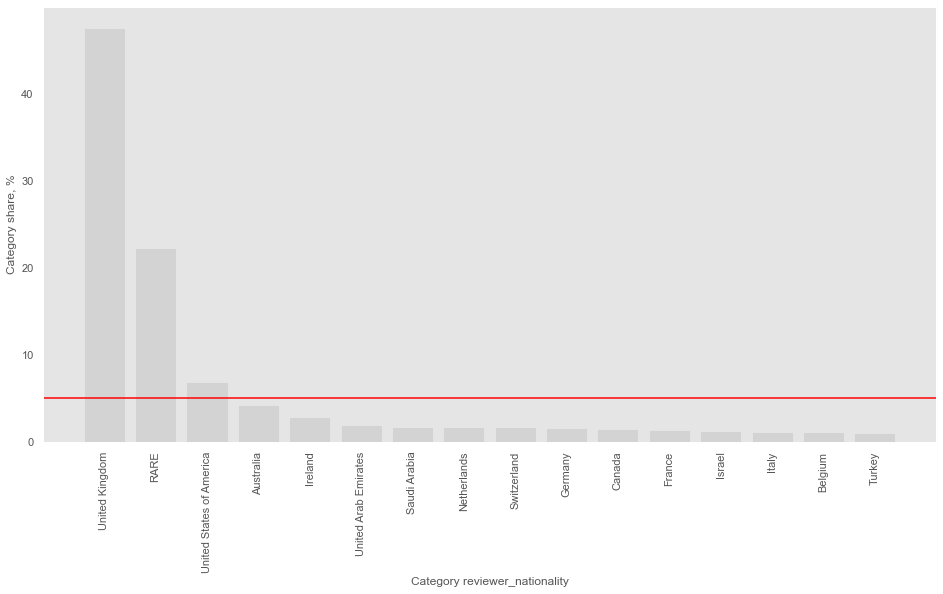

In [103]:
hd.plot_categories(full_data, 'reviewer_nationality', level=5)

In [104]:
# Категориальный, номинальный признак. Преобразую.
full_data['reviewer_nationality'] = full_data['reviewer_nationality'].astype('category')
category_nominal_columns.add('reviewer_nationality')

### Исследую tags

In [105]:
# Есть полные повторения
full_data['tags'].value_counts()

[' Leisure trip ', ' Couple ', ' Double Room '...    5101
[' Leisure trip ', ' Couple ', ' Standard Doub...    4931
[' Leisure trip ', ' Couple ', ' Superior Doub...    4366
[' Leisure trip ', ' Couple ', ' Deluxe Double...    3987
[' Leisure trip ', ' Couple ', ' Double Room '...    3291
                                                     ... 
[' Leisure trip ', ' Family with young childre...       1
[' Leisure trip ', ' Couple ', ' Wonderful Dou...       1
[' Couple ', ' Double Room with Two Double Bed...       1
[' Business trip ', ' Solo traveler ', ' Super...       1
[' Leisure trip ', ' Travelers with friends ',...       1
Name: tags, Length: 55242, dtype: Int64

In [106]:
# Списки строк в виде строк, нужно приводить к нормальным спискам
full_data['tags'][0]

"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']"

In [107]:
def get_tags_list(tags_string):
    tags_string = str(tags_string)
    
    tags_string = tags_string.replace('[', '').replace(']', '').replace('\'', '')
    tag_list = tags_string.split(',')
    
    # Удаляю из элементов списка лишние пробелы по сторонам
    # Помещаю эелементы в сет, что бы измежать потенциальных дубликатов тегов
    tag_set = set([i.strip() for i in tag_list])
    
    # Распаковываю назад в список
    tag_list = list(tag_set)
    
    tag_list.sort() # сортирую для удобства в алфавитном порядке
    
    return tag_list

In [108]:
full_data['tags'] = full_data['tags'].apply(get_tags_list)

In [109]:
full_data['tags']

0         [Couple, Leisure trip, Stayed 2 nights, Studio...
1         [Business trip, Couple, Standard Double Room, ...
2         [Leisure trip, Modern Double Room Echo, Solo t...
3         [Leisure trip, Solo traveler, Standard Room wi...
4         [Business trip, Couple, Standard Double or Twi...
                                ...                        
515426    [Business trip, Couple, Double Room, Stayed 4 ...
515427    [Couple, Double Room, Leisure trip, Stayed 2 n...
515428    [Business trip, Single Room, Solo traveler, St...
515429    [Executive Double or Twin Room, Leisure trip, ...
515430    [Couple, Leisure trip, Standard Room with Spa ...
Name: tags, Length: 515431, dtype: object

In [110]:
# Создаю признак количество тегов, которые поставил ревьювер
full_data['tags_num'] = full_data['tags'].apply(lambda x: len(x))

In [111]:
# Тегов ставится от 1 до 6
full_data['tags_num'].describe()

count   515431.00
mean         4.57
std          0.52
min          1.00
25%          4.00
50%          5.00
75%          5.00
max          6.00
Name: tags_num, dtype: float64

In [112]:
# Распределение количества тегов которые выставляли ревьюверы
# Интересно, что 1 тег поставили всего 6 раз, большинство выбирают 5 тегов
full_data['tags_num'].value_counts()

5    297661
4    211423
3      5501
6       755
2        85
1         6
Name: tags_num, dtype: int64

In [113]:
# Врядли 1 тег это очень хорошо, а 6 очень плохо. Или наоборот. Просто разные модели поведения.
# Поэтому считаю признак номинальным, категориальным
category_nominal_columns.add('tags_num')

### Сколько уникальных тегов представлено в наборе данных?

In [114]:
# Признак с тегами по всей выборке конвертирую в список списков тегов
list_of_list = full_data['tags'].to_list()

In [115]:
# Словарь, где ключами идет тег, а в значении сколько раз он использовался
tags_dict = dict()


for tag_list in list_of_list:
    for tag in tag_list:
            if tag in tags_dict:
                tags_dict[tag] = tags_dict[tag] + 1
            else:
                tags_dict[tag] = 1


In [116]:
# Словарь преобразую в датафрейм
tags_df = pd.DataFrame({'tag': tags_dict.keys(), 'frequency': tags_dict.values()}).sort_values(by=['frequency'], ascending=False).reset_index(drop=True)

In [117]:
# Визуально изучаю теги
tags_df.head(60)

,tag,frequency
0,Leisure trip,417538
1,Submitted from a mobile device,307470
2,Couple,252128
3,Stayed 1 night,193568
4,Stayed 2 nights,133850
5,Solo traveler,108476
6,Stayed 3 nights,95761
7,Business trip,82884
8,Group,65361
9,Family with young children,60989


In [118]:
# В тегах нашел информацию о количестве ночей проведенных в отеле
# Думаю это важная информация, ее можно выделить в отдельный числовой признак stayed_nights

# Создаю маску записей где в теге есть слово Stayed
stayed_mask = tags_df['tag'].apply(lambda x: x.find('Stayed') != -1)

In [119]:
tags_df[stayed_mask]

,tag,frequency
3,Stayed 1 night,193568
4,Stayed 2 nights,133850
6,Stayed 3 nights,95761
10,Stayed 4 nights,47777
17,Stayed 5 nights,20826
22,Stayed 6 nights,9765
26,Stayed 7 nights,7391
54,Stayed 8 nights,2499
75,Stayed 9 nights,1293
97,Stayed 10 nights,888


In [120]:
# Функция для выделения из тега Stayed числа ночей
def get_stayed_feature(tag_list):
    for tag in tag_list:
        if 'Stayed' in tag:
            num = tag.split()[1]
            return int(num)
    
    return 0 # Если тег не найден, тут вариант, либо ошибка, либо действительно остановка без ночевки

In [121]:
full_data['stayed_nights'] = full_data['tags'].apply(get_stayed_feature)

In [122]:
# Признак скорее категориальный. 
# Врядли порядковый, все же рассматриваю как номинальный.
# Нет такого что 0 дней это очень плохой отель, а 31 самый лучший. Ситуации и запросы у людей разные. На рейтинге врядли это сказывается прямопропорционально
full_data['stayed_nights'].value_counts()

1     193568
2     133850
3      95761
4      47777
5      20826
6       9765
7       7391
8       2499
9       1293
10       888
11       417
12       316
14       247
13       246
0        192
15       117
16        57
17        42
18        33
19        29
21        23
20        19
30        11
27        11
22        10
23        10
28         7
26         7
25         7
24         6
29         5
31         1
Name: stayed_nights, dtype: int64

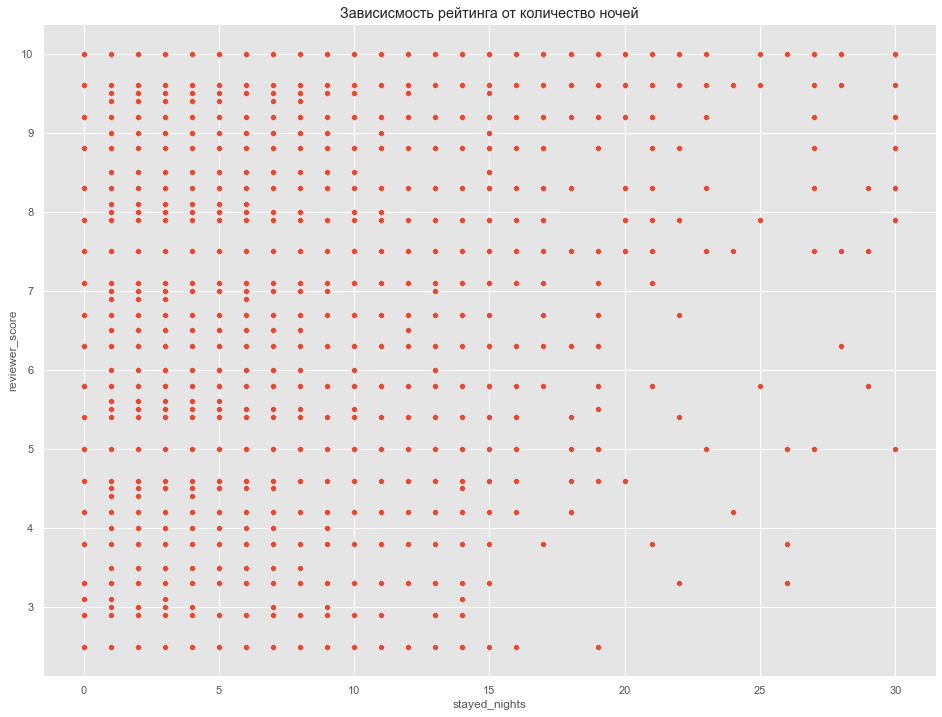

In [123]:
# На трейн датасете проверяю
fig = plt.figure(figsize=(16, 12))
hist = sns.scatterplot(data=full_data[full_data['dataset'] == 'train'], x='stayed_nights', y=TARGET_FEATURE)
hist.set_title('Зависисмость рейтинга от количество ночей');

Видно, что после 15-20 ночей рейтинг растет, в нижней части уже меньше точек, чем в верхней. Но зависимость очень слабая.

In [124]:
# Посмотрю корреляцию к целевому признаку на треин выборке. Корреляция оказалась нулевой
full_data[full_data['dataset'] == 'train'][['stayed_nights', TARGET_FEATURE]].corr()

,stayed_nights,reviewer_score
stayed_nights,1.00,-0.01
reviewer_score,-0.01,1.00


In [125]:
# lab_list_nights = ['0 nights', '1 night', 'less 2 weeks', 'more 2 weeks']
# order_list_nights = [-1, 1, 2, 15, 32]
# order_list_nights

# # Словарь для дальнейшей кодировки признака
# dict_for_ordinal_nights = dict(zip(lab_list_nights, order_list_nights))

# full_data['stayed_nights_cut'] = pd.cut(full_data['stayed_nights'], bins=order_list_nights, labels=lab_list_nights, include_lowest=True)

In [126]:
def stayed_more_one_night(stayed_nights):
    if stayed_nights > 1:
        return True
    
    return False

In [127]:
full_data['more_one_night'] = full_data['stayed_nights'].apply(stayed_more_one_night)

In [128]:
category_nominal_columns.add('more_one_night')

In [129]:
full_data.drop('stayed_nights', axis=1, inplace=True)

In [130]:
# def stayed_nights_cat(stayed_nights):
#     if stayed_nights == 0:
#         return '0 nights'
#     elif stayed_nights == 1:
#         return '1 night'
#     elif stayed_nights < 15:
#         return 'less 2 weeks'
#     else:
#         return 'more 2 weeks'

In [131]:
# full_data['stayed_nights'] = full_data['stayed_nights'].apply(stayed_nights_cat)

In [132]:
# Странное разделение, как вариант сделать поросто бинарный признак на одну ночь True, остальное False
# full_data['stayed_nights'].value_counts()

In [133]:
# full_data['stayed_nights'] = full_data['stayed_nights'].astype('category')

In [134]:
# Все же считаю признак категориальным номинальным
# Может стоит подумать о снижении числа уникальных значений через группировку:
# 0 - без ночевки. 1 - одна ночь. 2-14 - до двух недель. от 15 - от 2х недель. 
# category_nominal_columns.add('stayed_nights')

In [135]:
# По маске удаляю теги Stayed, что бы они не мешали дальнейшему анализу
# С помощью ~ инвертирую фильтр
tags_df = tags_df[~stayed_mask].reset_index(drop=True)

In [136]:
# Смотрю еще 60 тегов, дальше нет смысла, частота падает
# tags_df = tags_df.head(60)
# tags_df

In [137]:
# Маска для тегов в которых есть слово Rooom
room_mask = tags_df['tag'].apply(lambda x: x.find('Room') != -1)

In [138]:
# Теги без слова Room

# 2 rooms - есть еще 3. т.е. номера из 1 (по умолчанию все такие) 2х и 3х комнат. Можно выделить в отдельный признак
# 

# Submitted from a mobile device в современном мире важный показатель, канал коммуникации клиента.

# Думаю топ 15 можно использовать как отдельные признаки. Couple - Solo traveler - Family with young children - Family with older children - 
tags_df[~room_mask].head(60)

,tag,frequency
0,Leisure trip,417538
1,Submitted from a mobile device,307470
2,Couple,252128
3,Solo traveler,108476
4,Business trip,82884
5,Group,65361
6,Family with young children,60989
10,Family with older children,26334
16,2 rooms,12384
29,Junior Suite,4555


### rooms признак количество комнат в номере

In [139]:
def get_rooms_feature(tags):
    # обхожу список тегов
    for tag in tags:
        # если в теге есть слово
        if 'rooms' in tag:
            num_rooms = tag.split()[0]
            
            if num_rooms.lower() == 'two':
                return 2
            elif num_rooms.lower() == 'three':
                return 2
            
            try:
                return int(num_rooms)
            
            except ValueError as e:
                return 1
    
    return 1 # Если обойдя список тегов не нашел тег с количеством комнат, то считаю что это сттандартный однокомнатный номер

In [140]:
full_data['rooms'] = full_data['tags'].apply(get_rooms_feature)

In [141]:
# Получается что 97% номеров с 1 комнатой, признак получается малоинформативным
full_data['rooms'].value_counts(True) * 100

1   97.49
2    2.41
3    0.09
4    0.01
5    0.00
Name: rooms, dtype: float64

In [142]:
# Маска для тегов в которых есть слово именно слово rooom, без вхождения в другие слова типа Bathrooms, Bedrooms.
rooms_mask = tags_df['tag'].apply(lambda x: len(re.findall(r'\brooms\b', x)) > 0)

In [143]:
tags_df[rooms_mask]

,tag,frequency
16,2 rooms,12384
120,3 rooms,474
742,4 rooms,38
1287,Family Suite with two connecting rooms,13
1371,Two Connecting Double and Twin rooms,11
1778,5 rooms,5
2266,Family Suite with adjoining rooms,1


Сделаю признак rooms бинарным, пусть он возвращает True, когда в тегах найдена информация о каком-то количестве комнат.\
Иначем пусть возвращает False - это стандартные однокомнатные номера.

In [144]:
def get_rooms_boolean_feature(tags):
    # обхожу список тегов
    for tag in tags:
        # если в теге есть слово rooms
        if len(re.findall(r'\brooms\b', tag)) > 0:
            return True
            
    return False # Если обойдя список тегов не нашел тег со словом room, то считаю номер однокомнатным

In [145]:
full_data['rooms'] = full_data['tags'].apply(get_rooms_boolean_feature)

In [146]:
# Признак по-прежнему малоинформативный, но все же, пока оставлю
full_data['rooms'].value_counts(True) * 100

False   97.49
True     2.51
Name: rooms, dtype: float64

In [147]:
# Категориальный номинальный признак
category_nominal_columns.add('rooms')

In [148]:
# Убираю обработанные теги со словом rooms
tags_df = tags_df[~rooms_mask]

In [149]:
tags_df.head(60)

,tag,frequency
0,Leisure trip,417538
1,Submitted from a mobile device,307470
2,Couple,252128
3,Solo traveler,108476
4,Business trip,82884
5,Group,65361
6,Family with young children,60989
7,Double Room,35207
8,Standard Double Room,32247
9,Superior Double Room,31361


In [150]:
# Вот такие признаки выделяю

# Тип кроватей:
# Single - номер на одного
# Twin - две кровати
# Double - одна кровать на двоих
# King
# Queen
# Family
bed_type = ['Single', 'Twin', 'Double', 'King', 'Queen', 'Family']

# Класс удобства:
# Classic
# Standard
# Deluxe
# Executive
# Superior
servise_type = ['Classic', 'Standard', 'Deluxe', 'Executive', 'Superior']

# Тип номера:
# Room
# Studio
# Suite
# Apartment
room_type = ['Room', 'Studio', 'Suite', 'Apartment']

In [151]:
def get_category_feature(tags, category_list):
    for tag in tags:
        for cat in category_list:
            if cat in tag:
                return cat
    
    return 'Unknown'

### bed_type

In [152]:
full_data['bed_type'] = full_data['tags'].apply(get_category_feature, args=(bed_type,))

In [153]:
full_data['bed_type'].value_counts(True) * 100

Double    39.43
Twin      23.50
Family    12.27
Unknown    9.32
King       5.57
Single     5.09
Queen      4.82
Name: bed_type, dtype: float64

In [154]:
full_data['bed_type'] = full_data['bed_type'].astype('category')
category_nominal_columns.add('bed_type')

### servise_type

In [155]:
full_data['servise_type'] = full_data['tags'].apply(get_category_feature, args=(servise_type,))

In [156]:
full_data['servise_type'].value_counts(True) * 100

Unknown     43.03
Standard    16.94
Superior    16.58
Deluxe      12.78
Classic      6.95
Executive    3.71
Name: servise_type, dtype: float64

In [157]:
full_data['servise_type'] = full_data['servise_type'].astype('category')
category_nominal_columns.add('servise_type')

### room_type

In [158]:
full_data['room_type'] = full_data['tags'].apply(get_category_feature, args=(room_type,))

In [159]:
full_data['room_type'].value_counts(True) * 100

Room        90.70
Unknown      4.73
Suite        3.07
Studio       1.18
Apartment    0.33
Name: room_type, dtype: float64

In [160]:
full_data['room_type'] = full_data['room_type'].astype('category')
category_nominal_columns.add('room_type')

### Оставшиеся, наиболее частые теги

In [161]:
# Остались в топе интересные теги

# Submitted from a mobile device заказ через приложение на смартфоне, как отдельный бинарный признак from_mobile

# Типы поездок
# Leisure trip
# Couple
# Solo traveler
# Business trip
# Group
trip_type = ['Leisure trip', 'Couple', 'Solo traveler', 'Business trip', 'Group']

# дети
# Family with young children
# Family with older children
children_type = ['Family with young children', 'Family with older children']
	
tags_df.head(60)

,tag,frequency
0,Leisure trip,417538
1,Submitted from a mobile device,307470
2,Couple,252128
3,Solo traveler,108476
4,Business trip,82884
5,Group,65361
6,Family with young children,60989
7,Double Room,35207
8,Standard Double Room,32247
9,Superior Double Room,31361


### from_mobile

In [162]:
def from_mobile_feature(tags):
    for tag in tags:
        if 'Submitted from a mobile device' in tag:
            return True
    
    return False

In [163]:
full_data['from_mobile'] = full_data['tags'].apply(from_mobile_feature)

In [164]:
full_data['from_mobile'].value_counts(True) * 100 

True    59.65
False   40.35
Name: from_mobile, dtype: float64

In [165]:
category_nominal_columns.add('from_mobile')

### trip_type

In [166]:
full_data['trip_type'] = full_data['tags'].apply(get_category_feature, args=(trip_type,))

In [167]:
# Две последние категории совсем не нравятся, они очень маленькие
full_data['trip_type'].value_counts(True) * 100

Couple          46.16
Leisure trip    25.02
Business trip   16.08
Group           11.27
Solo traveler    0.84
Unknown          0.63
Name: trip_type, dtype: float64

In [168]:
full_data['trip_type'] = full_data['trip_type'].astype('category')
category_nominal_columns.add('trip_type')

### children_type

In [169]:
full_data['children_type'] = full_data['tags'].apply(get_category_feature, args=(children_type,))

In [170]:
full_data['children_type'].value_counts(True) * 100

Unknown                      83.06
Family with young children   11.83
Family with older children    5.11
Name: children_type, dtype: float64

In [171]:
full_data['children_type'] = full_data['children_type'].astype('category')
category_nominal_columns.add('children_type')

Признак tags можно удалить, оттуда уже ничего больше вытаскивать не буду

In [172]:
full_data.drop('tags', axis=1, inplace=True)

### EXPLORE: additional_number_of_scoring

In [173]:
full_data['additional_number_of_scoring'].describe()

count   515431.00
mean       498.28
std        500.62
min          1.00
25%        169.00
50%        342.00
75%        660.00
max       2682.00
Name: additional_number_of_scoring, dtype: float64

In [174]:
full_data['additional_number_of_scoring'].value_counts(True) * 100

2682   0.93
2288   0.83
2623   0.81
1831   0.69
1936   0.62
       ... 
7      0.01
5      0.01
17     0.00
1      0.00
4      0.00
Name: additional_number_of_scoring, Length: 480, dtype: Float64

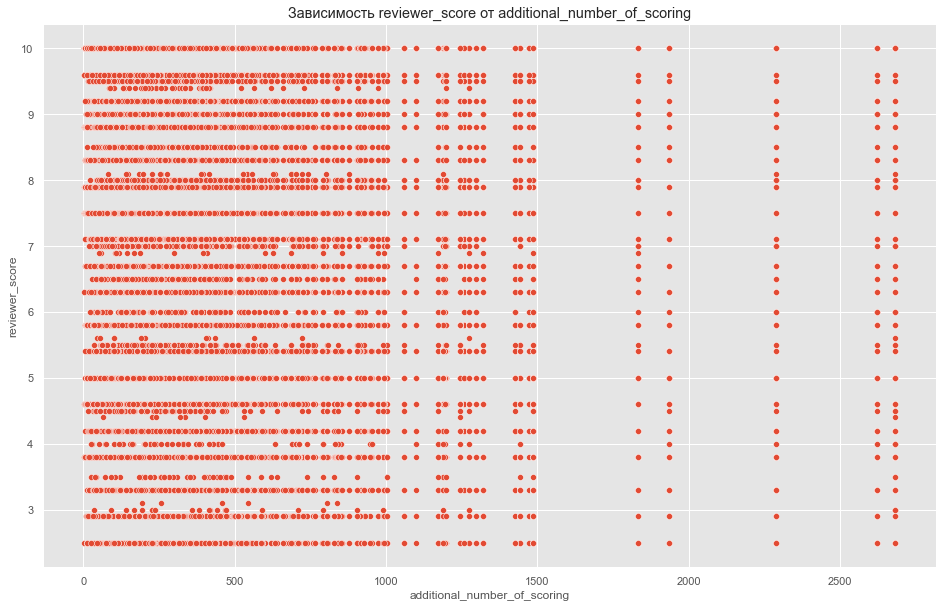

In [175]:
# Не знаю... Не вижу связи
fig = plt.figure(figsize=(16, 10))
hist = sns.scatterplot(data=full_data[full_data['dataset'] == 'train'], x='additional_number_of_scoring', y='reviewer_score')
hist.set_title('Зависимость reviewer_score от additional_number_of_scoring');

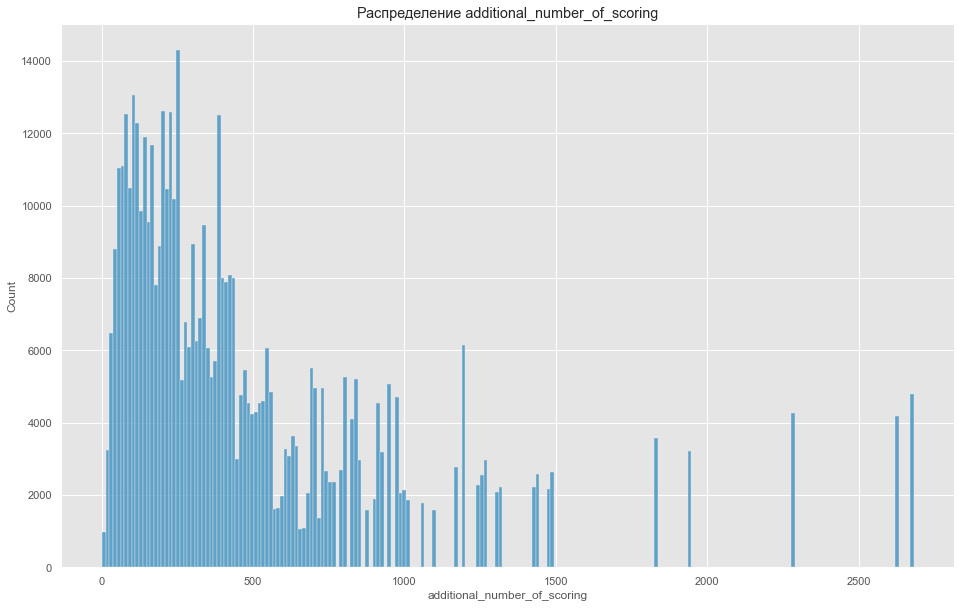

In [176]:
fig = plt.figure(figsize=(16, 10))
hist = sns.histplot(data=full_data, x='additional_number_of_scoring')
hist.set_title('Распределение additional_number_of_scoring');

### EXPLORE: negative_review

In [177]:
full_data['negative_review'][0]

' Leaving '

In [178]:
# Вжу лишние пробелы. Удаляю и всё перевожу в нижний регистр
full_data['negative_review'] = full_data['negative_review'].str.strip().str.lower()

In [179]:
# 320 тыс уникальных негативных отзыва
all_neg_review = list(full_data['negative_review'].value_counts().index)
print(len(all_neg_review))
all_neg_review

323166


['no negative',
 'nothing',
 'n a',
 'none',
 '',
 'nothing really',
 'small room',
 'breakfast',
 'all good',
 'no complaints',
 'location',
 'nothing at all',
 'everything',
 'nothing to dislike',
 'price',
 'nil',
 'small rooms',
 'everything was perfect',
 'na',
 'can t think of anything',
 'leaving',
 'absolutely nothing',
 'everything was great',
 'expensive',
 'nothing to complain about',
 'no',
 'room size',
 'very small room',
 'nothing not to like',
 'nothing all good',
 'staff',
 'having to leave',
 'not much',
 'i liked everything',
 'everything was good',
 'liked everything',
 'see above',
 'expensive breakfast',
 'nothing it was perfect',
 'non',
 'nothing everything was perfect',
 'the price',
 'room too small',
 'room was very small',
 'nothing in particular',
 'everything was fine',
 'nothing everything was great',
 'not applicable',
 'all was good',
 'wifi',
 'pillows',
 'parking',
 'size of room',
 'very small rooms',
 'breakfast not included',
 'room very small',
 '

In [180]:
full_data[['negative_review', 'review_total_negative_word_counts']].head(60)

,negative_review,review_total_negative_word_counts
0,leaving,3
1,poor breakfast,3
2,no kettle in room,6
3,no negative,0
4,torn sheets,4
5,nothing,2
6,nothing it was lovely,6
7,the communal areas are a bit soul less and the...,40
8,undergoing refurbishment no tea coffer in room...,30
9,i advised it was for my husbands birthday and ...,47


In [181]:
full_data[full_data['negative_review'] == 'nothing']

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,is_reviewer_citizen,tags_num,more_one_night,rooms,bed_type,servise_type,room_type,from_mobile,trip_type,children_type
5,105,8.00,Novotel Milano Linate Aeroporto,France,nothing,2,1607,Very nice hotel Price is excellent when compa...,16,1,...,False,5,False,False,Twin,Superior,Room,True,Business trip,Unknown
17,1172,7.80,Holiday Inn London Kensington,United Kingdom,nothing,3,5945,Brilliant location just 100 yds or so off Ken...,36,2,...,True,5,True,False,Unknown,Standard,Room,True,Group,Unknown
37,531,9.00,The Piccadilly London West End,RARE,nothing,3,2298,This hotel is well located in the Soho area s...,53,5,...,False,5,False,False,Double,Unknown,Room,True,Couple,Unknown
76,137,8.60,Henley House Hotel,United Kingdom,nothing,2,1179,The breakfast is excellent rooms clean very c...,35,1,...,True,4,True,False,Twin,Deluxe,Room,True,Unknown,Family with young children
84,218,8.50,Acta Atrium Palace,RARE,nothing,2,1933,Everything,2,1,...,False,5,True,False,Twin,Unknown,Room,True,Business trip,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515352,94,9.20,Appartement Hotel an der Riemergasse,Germany,nothing,2,969,Nice old building and especially the elevator...,22,20,...,False,4,True,False,Unknown,Unknown,Studio,False,Business trip,Unknown
515365,375,9.30,The Langham London,United Kingdom,nothing,2,1276,Everything,2,7,...,True,5,True,False,Double,Superior,Room,True,Leisure trip,Unknown
515385,540,8.90,St George s Hotel Wembley,United Kingdom,nothing,2,2274,Manager Miria was really nice fantastic,7,1,...,True,4,False,False,Twin,Deluxe,Room,False,Leisure trip,Unknown
515392,114,8.70,Hotel Indigo London Paddington,United Kingdom,nothing,3,602,Perfect for one night in London Free upgrade ...,24,1,...,True,4,False,False,King,Executive,Room,False,Couple,Unknown


In [182]:
full_data['review_word_diff'] = full_data['review_total_positive_word_counts'] - full_data['review_total_negative_word_counts']

In [183]:
full_data['review_word_diff'].value_counts()

0      15850
3      14530
2      14169
4      14121
5      13862
       ...  
381        1
270        1
308        1
368        1
338        1
Name: review_word_diff, Length: 737, dtype: Int64

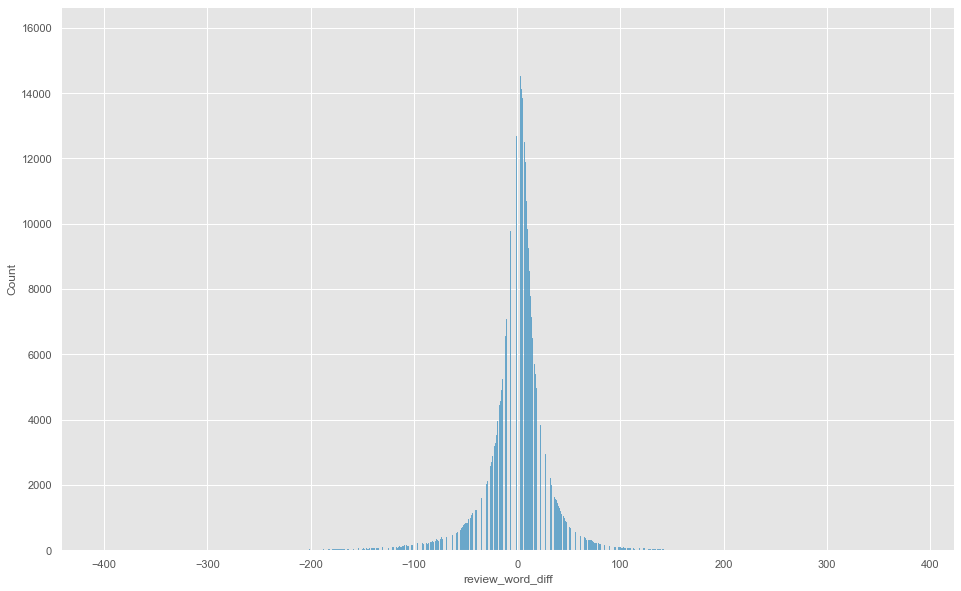

In [184]:
fig = plt.figure(figsize=(16, 10))
hist = sns.histplot(data=full_data, x='review_word_diff')
# hist.set_title('Распределение additional_number_of_scoring');

### 0.8. Delete useless features

In [185]:
full_data = full_data.convert_dtypes()

In [186]:
# Убираю признаки, которые либо пока, либо вовсе не будут обрабатываться
string_columns = [col_name for col_name in full_data.columns if full_data[col_name].dtypes == 'string']
string_columns

['hotel_name', 'negative_review', 'positive_review']

In [187]:
full_data.drop(string_columns, axis = 1, inplace=True)

### 0.9. Code features

In [188]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515431 entries, 0 to 515430
Data columns (total 33 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   additional_number_of_scoring                515431 non-null  Int64   
 1   average_score                               515431 non-null  Float64 
 2   reviewer_nationality                        515431 non-null  category
 3   review_total_negative_word_counts           515431 non-null  Int64   
 4   total_number_of_reviews                     515431 non-null  Int64   
 5   review_total_positive_word_counts           515431 non-null  Int64   
 6   total_number_of_reviews_reviewer_has_given  515431 non-null  Int64   
 7   days_since_review                           515431 non-null  Int64   
 8   lat                                         515431 non-null  Float64 
 9   lng                                         515431 non-null

### ONE-HOT ENCODING / BINARY ENCODING
Категориальные номинальные признаки

In [189]:
category_nominal_columns

{'bed_type',
 'children_type',
 'city',
 'country',
 'day_of_week',
 'from_mobile',
 'is_capital',
 'is_reviewer_citizen',
 'month',
 'more_one_night',
 'quarter',
 'reviewer_nationality',
 'room_type',
 'rooms',
 'servise_type',
 'tags_num',
 'trip_type'}

In [190]:
full_data = pd.get_dummies(full_data, columns=category_nominal_columns, drop_first=True)

### Ordinal Encoding
Порядковые категориальные признаки

In [191]:
category_ordinal_columns

set()

In [192]:
# maplist = [{'col': 'average_score_cat', 'mapping': dict_for_ordinal}]

In [193]:
# oe = ce.OrdinalEncoder(mapping=maplist)
# full_data = oe.fit_transform(full_data, return_df=True)

In [194]:
full_data = hd.reformat_columns(full_data, TARGET_FEATURE)

### 0.9. Scaling features

In [195]:
# Последние два признака это маркер датасета и целевой признак
cols_for_scaling = full_data.columns[:-2]
cols_not_scaling = full_data.columns[-2:]

In [196]:
from sklearn import preprocessing

In [197]:
# mms = preprocessing.MinMaxScaler()
mms = preprocessing.RobustScaler()

In [198]:
transform = mms.fit_transform(full_data[cols_for_scaling])

In [199]:
transform_data = pd.DataFrame(transform, columns=cols_for_scaling)

In [200]:
transform_full_data = pd.concat([transform_data, full_data[cols_not_scaling]], axis=1)

### 0.9. Corralation analysis. Select features

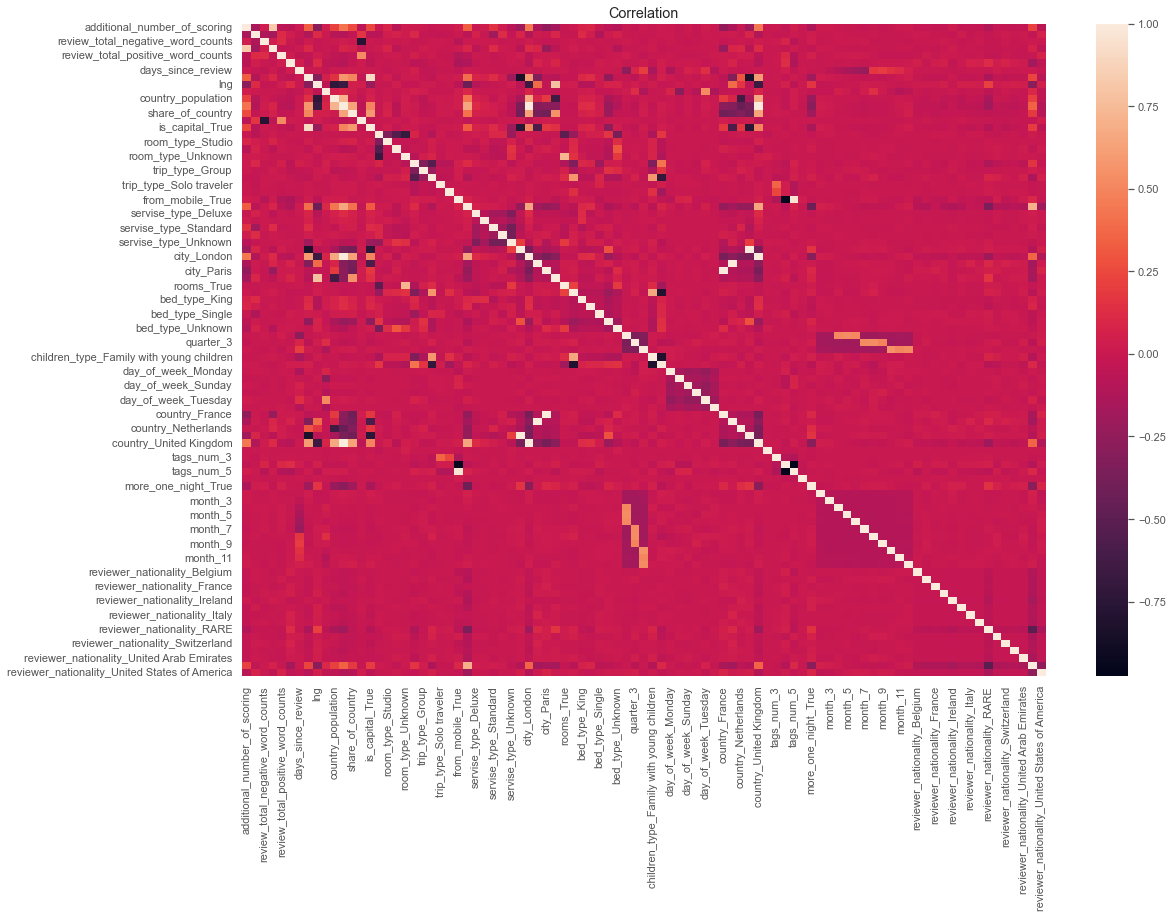

In [201]:
fig = plt.figure(figsize=(18, 12))
hm = sns.heatmap(transform_full_data.drop(cols_not_scaling, axis=1).corr(), annot=False, fmt='.1g')
hm.set_title('Correlation');

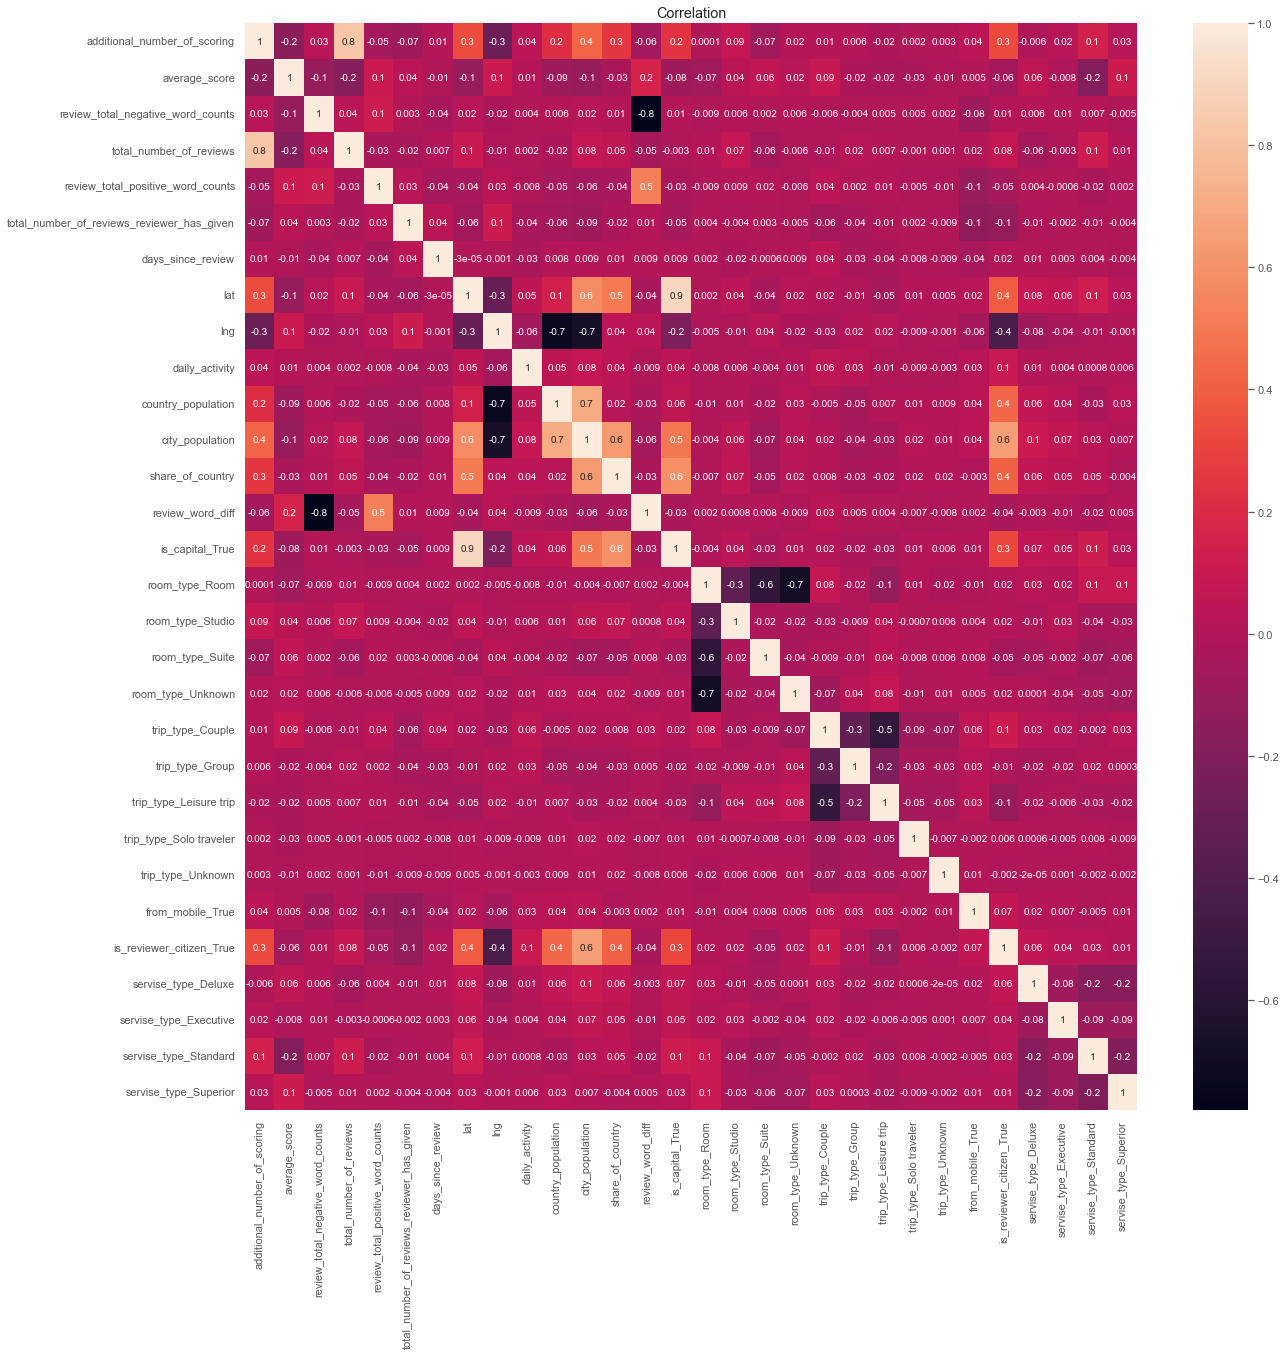

In [202]:
cols = transform_full_data.columns
small = transform_full_data[cols[:30]]

fig = plt.figure(figsize=(20, 20))
hm = sns.heatmap(small.corr(), annot=True, fmt='.1g')
hm.set_title('Correlation');

In [203]:
transform_full_data.drop(['lat', 'lng'], axis=1, inplace=True)

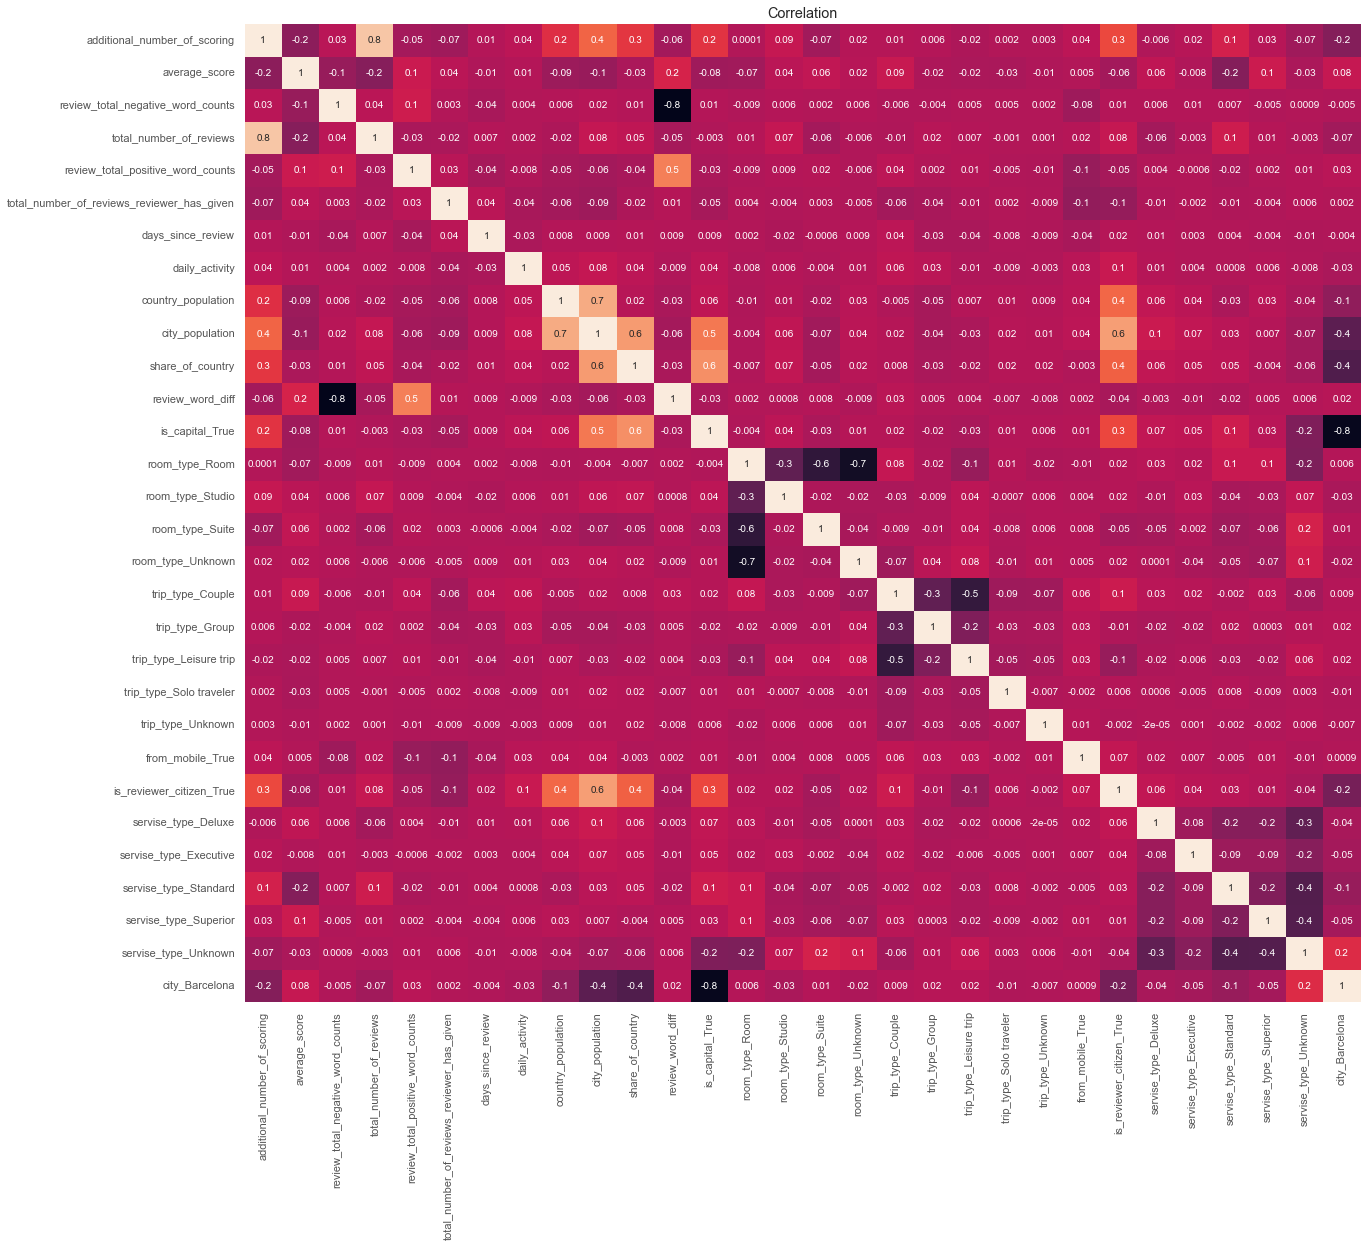

In [204]:
cols = transform_full_data.columns
small = transform_full_data[cols[:30]]

fig = plt.figure(figsize=(20, 18))
hm = sns.heatmap(small.corr(), annot=True, fmt='.1g', cbar=False)
hm.set_title('Correlation');

In [205]:
# fig = plt.figure(figsize=(14, 8))
# sns.lmplot(x='average_score', y='average_score_cat', data=transform_full_data, order=1)

In [206]:
# Корреляция очевидна, удаляю исходный признак. Потом можно попробовать удалить cat и попробовать исходный
# transform_full_data.drop('average_score', axis=1, inplace=True)

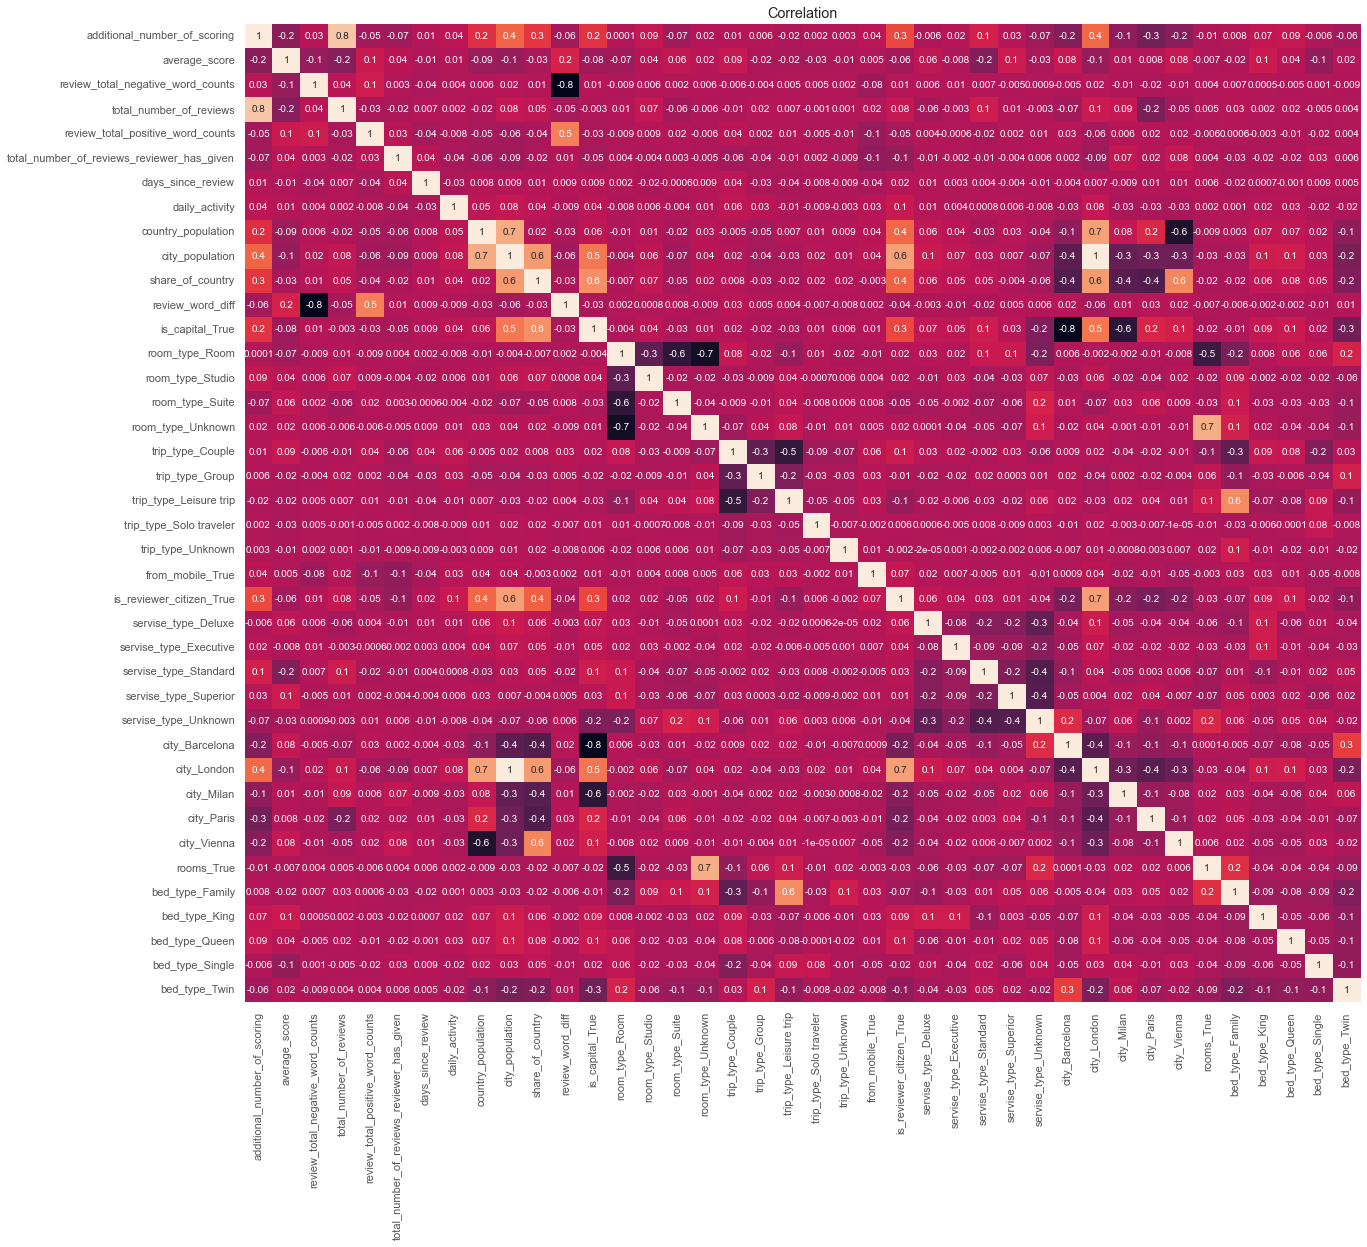

In [207]:
cols = transform_full_data.columns
small = transform_full_data[cols[:40]]

fig = plt.figure(figsize=(20, 18))
hm = sns.heatmap(small.corr(), annot=True, fmt='.1g', cbar=False)
hm.set_title('Correlation');

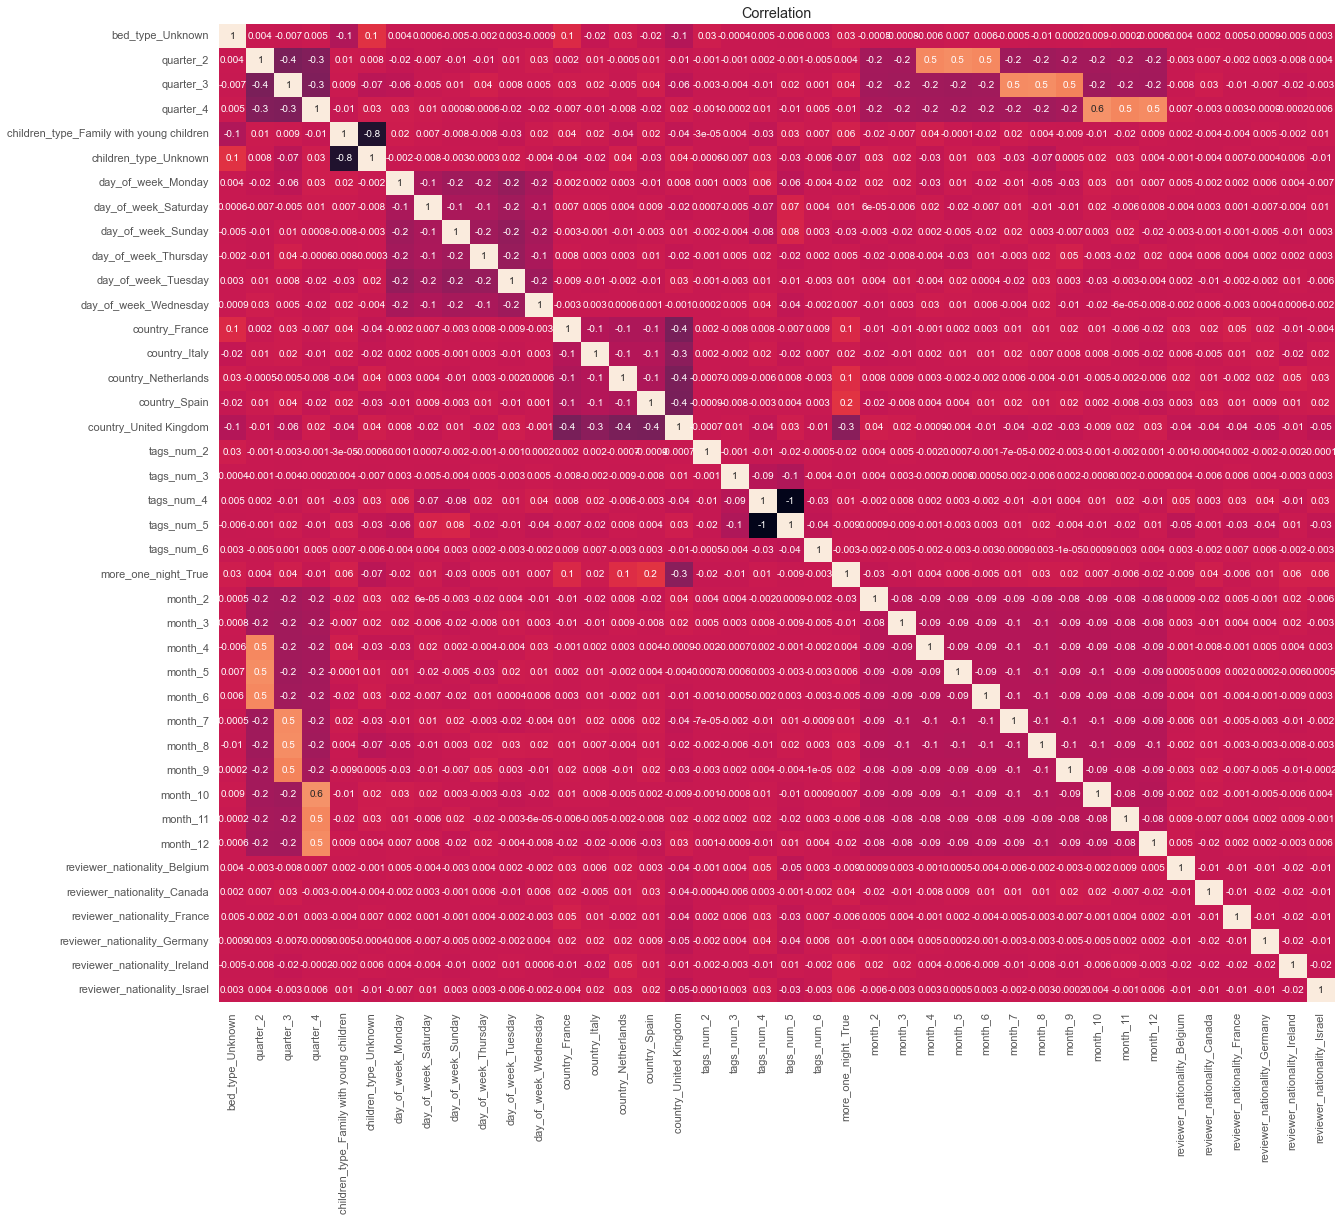

In [208]:
cols = transform_full_data.columns
small = transform_full_data[cols[40:80]]

fig = plt.figure(figsize=(20, 18))
hm = sns.heatmap(small.corr(), annot=True, fmt='.1g', cbar=False)
hm.set_title('Correlation');

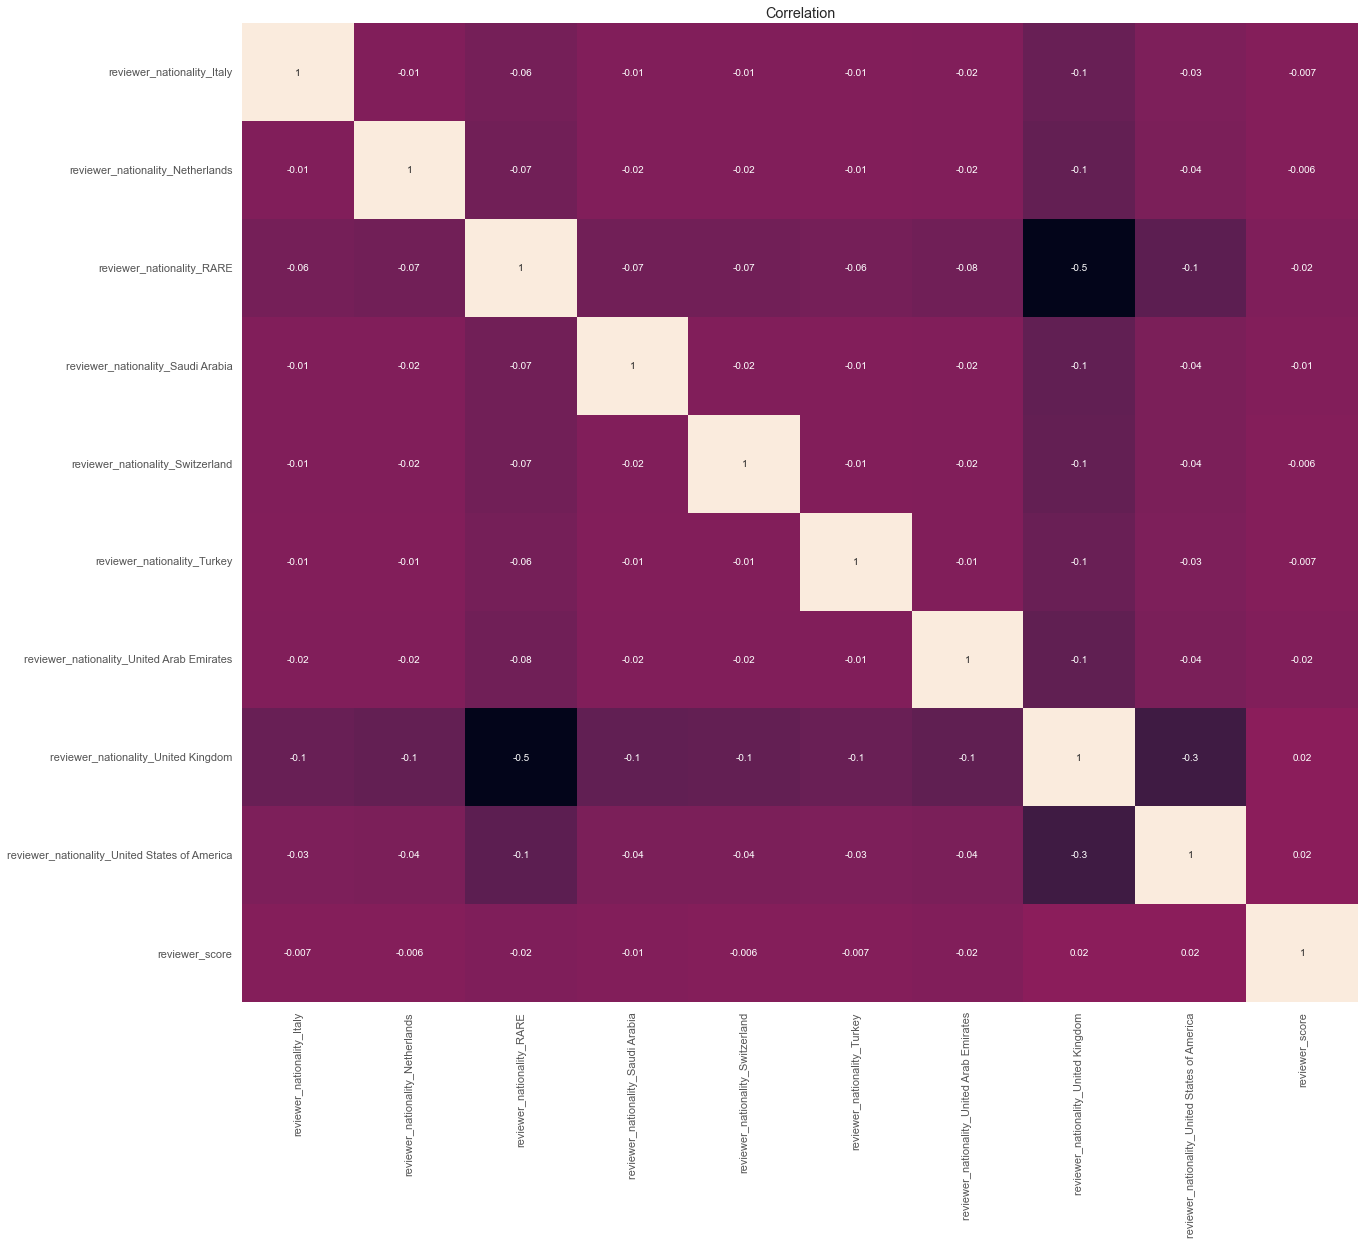

In [209]:
cols = transform_full_data.columns
small = transform_full_data[cols[80:]]

fig = plt.figure(figsize=(20, 18))
hm = sns.heatmap(small.corr(), annot=True, fmt='.1g', cbar=False)
hm.set_title('Correlation');

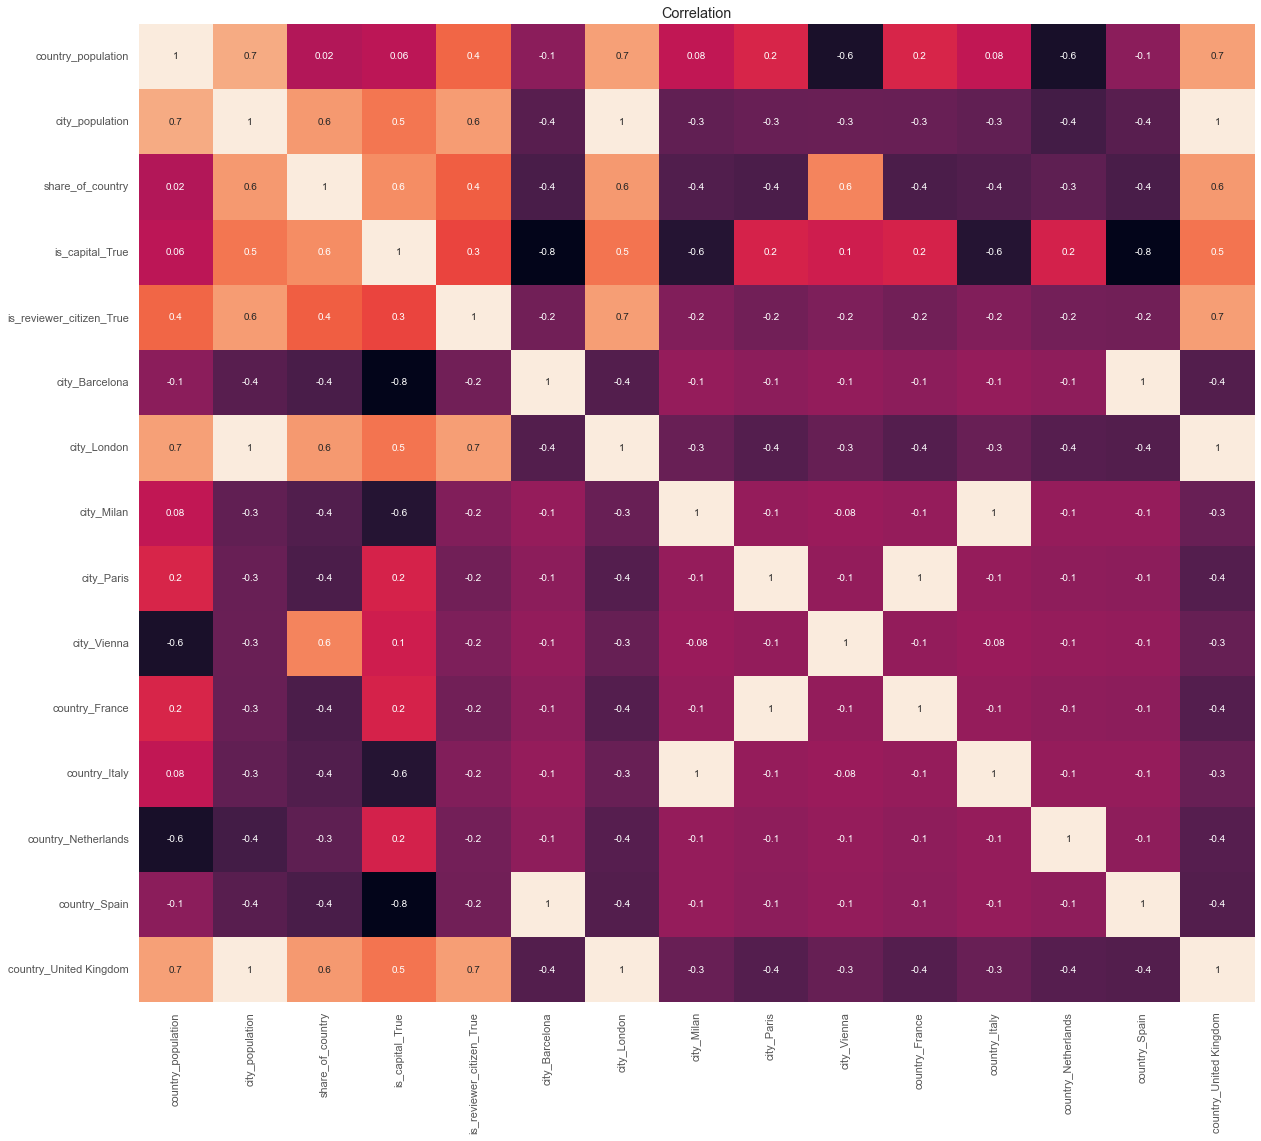

In [210]:
col_lst = [x for x in transform_full_data.columns if ('country' in x) or ('city' in x) or ('capital' in x) or ('citizen' in x)]
small = transform_full_data[col_lst]

fig = plt.figure(figsize=(20, 18))
hm = sns.heatmap(small.corr(), annot=True, fmt='.1g', cbar=False)
hm.set_title('Correlation');

In [211]:
drop_country = [x for x in transform_full_data.columns if ('country' in x)]
drop_country[2:]

['country_France',
 'country_Italy',
 'country_Netherlands',
 'country_Spain',
 'country_United Kingdom']

In [212]:
# Удаляю признаки стран
transform_full_data.drop(drop_country[2:], axis=1, inplace=True)

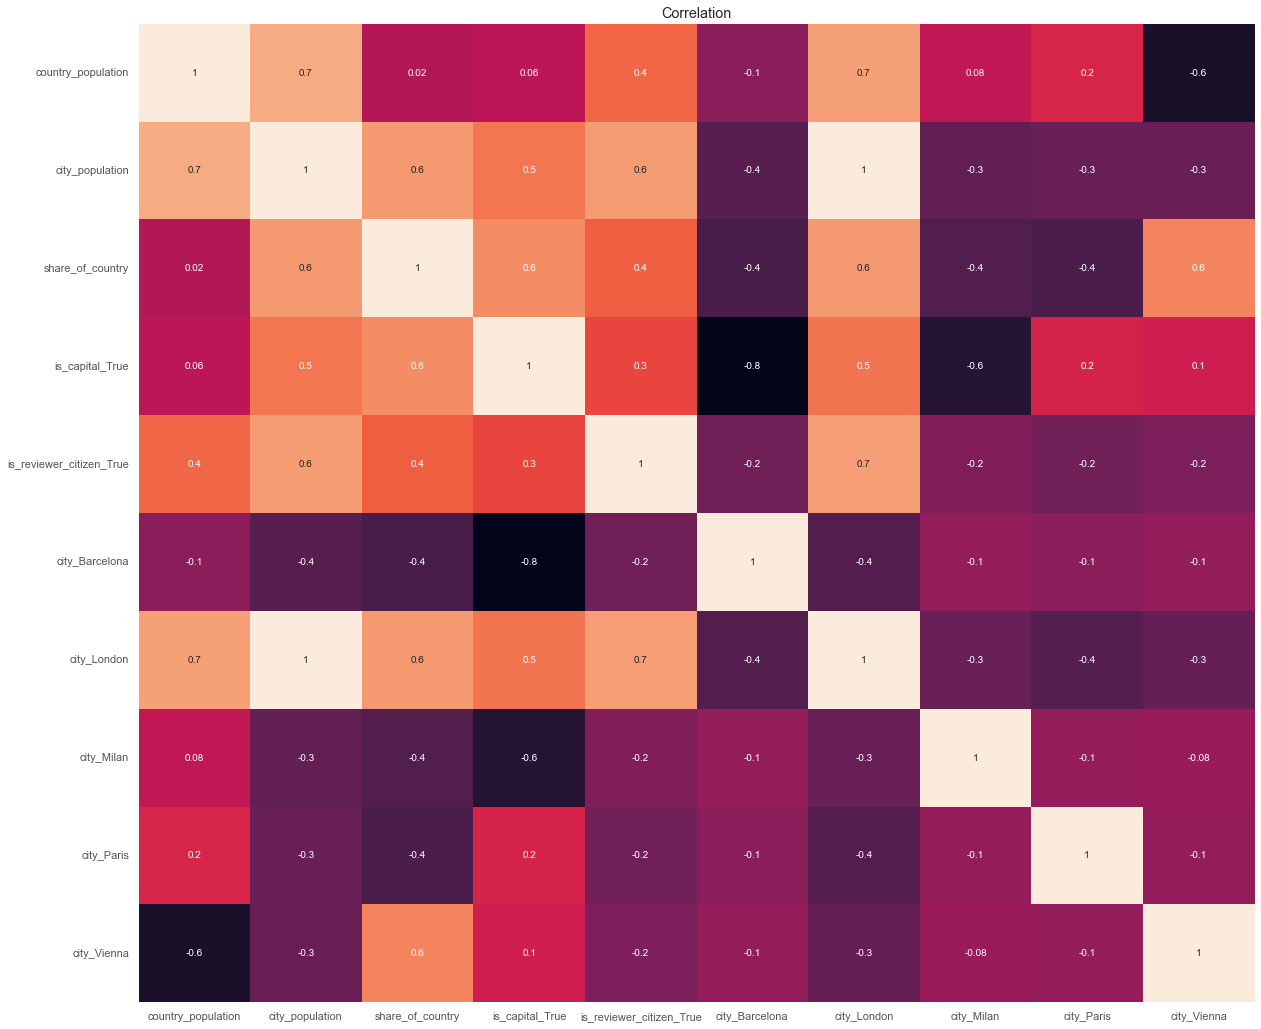

In [213]:
col_lst = [x for x in transform_full_data.columns if ('country' in x) or ('city' in x) or ('capital' in x) or ('citizen' in x)]
small = transform_full_data[col_lst]

fig = plt.figure(figsize=(20, 18))
hm = sns.heatmap(small.corr(), annot=True, fmt='.1g', cbar=False)
hm.set_title('Correlation');

In [214]:
for_drop = [x for x in transform_full_data.columns if ('population' in x)]
for_drop

['country_population', 'city_population']

In [215]:
transform_full_data.drop(for_drop, axis=1, inplace=True)

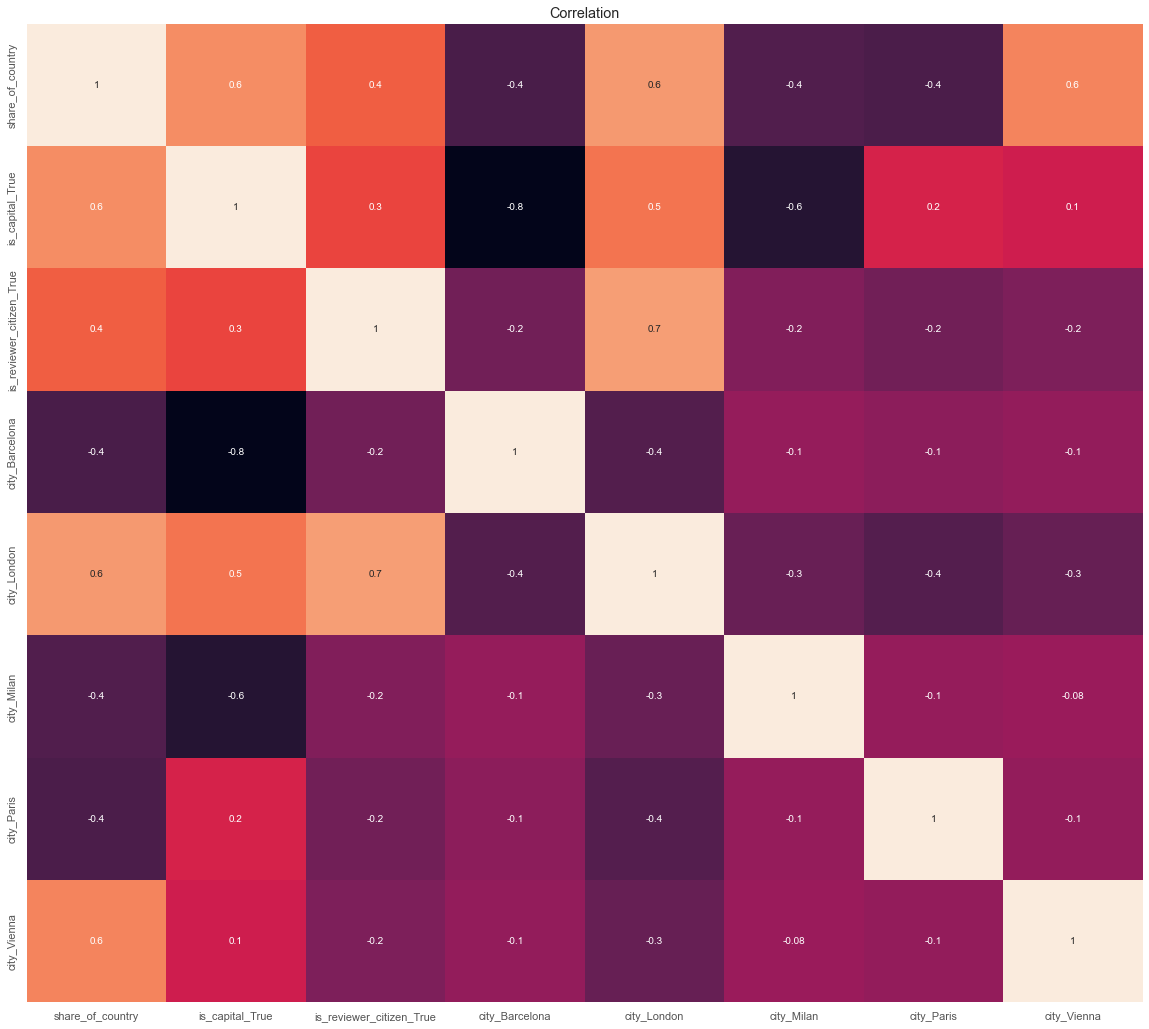

In [216]:
col_lst = [x for x in transform_full_data.columns if ('country' in x) or ('city' in x) or ('capital' in x) or ('citizen' in x)]
small = transform_full_data[col_lst]

fig = plt.figure(figsize=(20, 18))
hm = sns.heatmap(small.corr(), annot=True, fmt='.1g', cbar=False)
hm.set_title('Correlation');

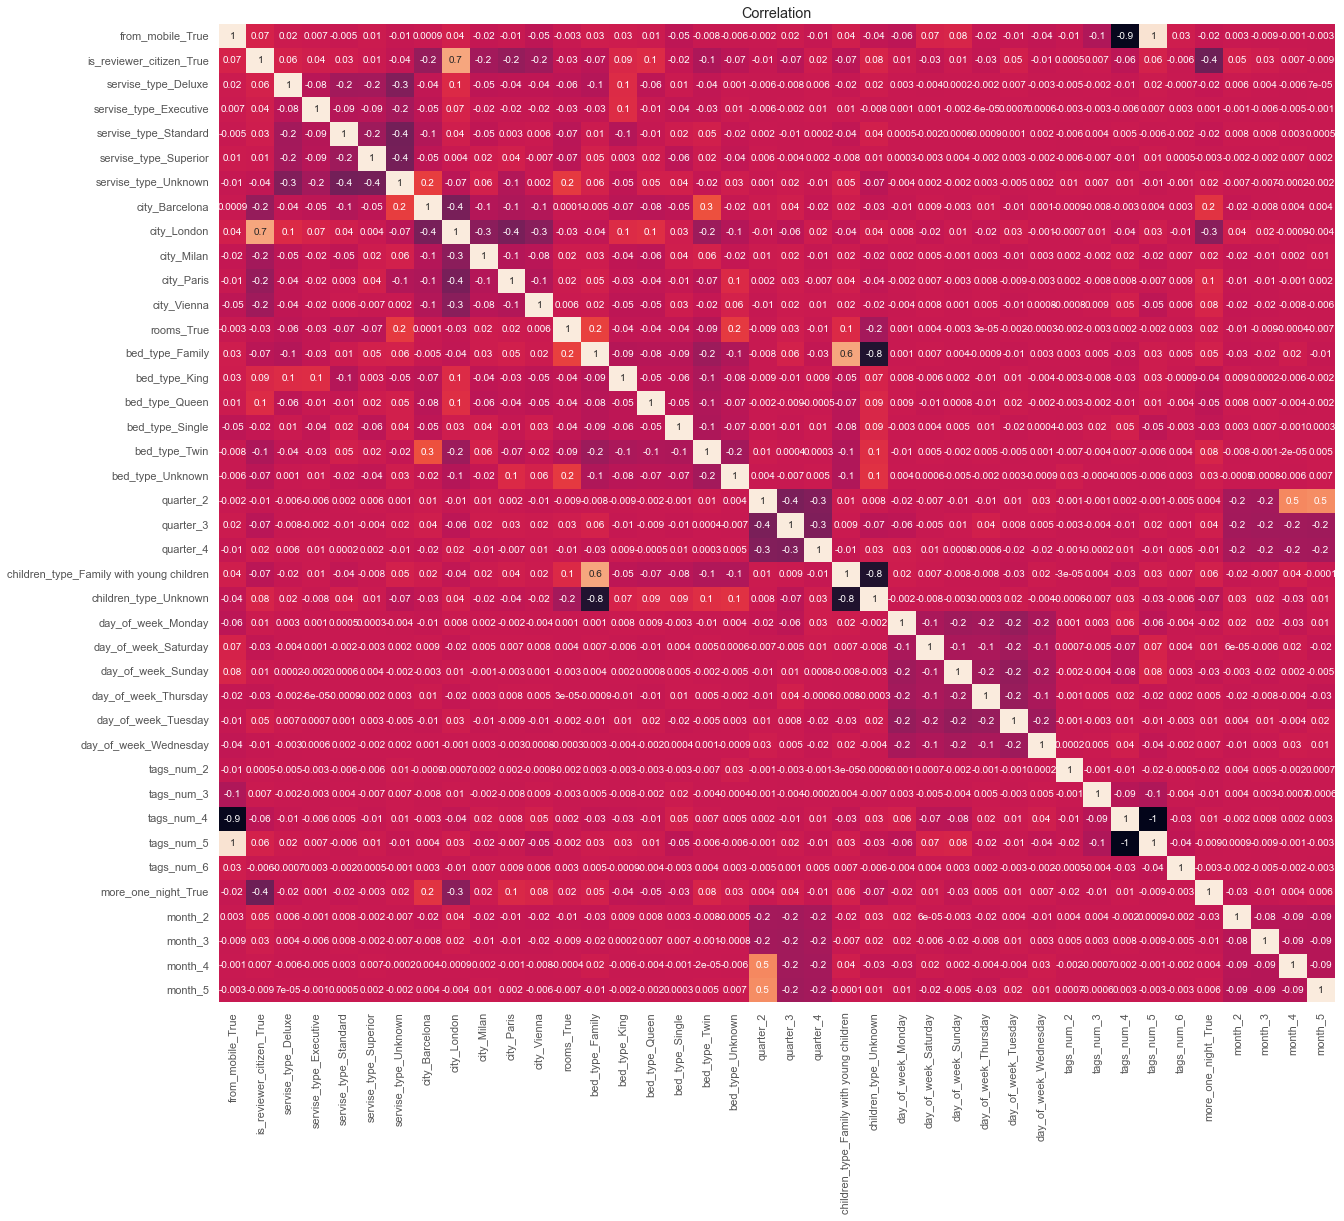

In [217]:
cols = transform_full_data.columns
small = transform_full_data[cols[20:60]]

fig = plt.figure(figsize=(20, 18))
hm = sns.heatmap(small.corr(), annot=True, fmt='.1g', cbar=False)
hm.set_title('Correlation');

### 1.0. Split full dataset again to train and test

In [218]:
train_data, test_data = hd.split_full_to_train_and_test(transform_full_data, TARGET_FEATURE)
print(train_data.shape)
print(test_data.shape)

(386496, 83)
(128935, 82)


In [219]:
# Из трейна датасета выделяю предикторы и целевой признак, X и y
X, y = hd.get_X_y_dataset(train_data, TARGET_FEATURE)

In [220]:
# Разбиваю треин данные на X и y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [221]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [222]:
%%time
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_STATE)
# Обучаем модель на части треинингового датасета
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   45.5s


CPU times: total: 24min 1s
Wall time: 2min 13s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [223]:
%%time
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print('***************************************************')
print('MAPE on train set:', metrics.mean_absolute_percentage_error(y_train, train_pred))
print('MAPE on test set:', metrics.mean_absolute_percentage_error(y_test, test_pred))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    3.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s


***************************************************
MAPE on train set: 0.05003047848819068
MAPE on test set: 0.1350286639183126
CPU times: total: 51.2 s
Wall time: 5.06 s


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.9s finished


MAPE on train set: 0.05003003516096103

MAPE on test set: 0.13503026342677796

### ReLearn on full train dataset

In [224]:
%%time
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_STATE)
# Обучаем модель полном треининговом датасете
model.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min


CPU times: total: 32min 39s
Wall time: 3min 9s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [225]:
%%time
full_train_pred = model.predict(X)

print()
print('MAPE on FULL train set:', metrics.mean_absolute_percentage_error(y, full_train_pred))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.6s



MAPE on FULL train set: 0.050067586937553976
CPU times: total: 54.6 s
Wall time: 5.25 s


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    5.0s finished


MAPE on FULL train set: 0.05006961316679829

In [226]:
# Получаю результат предсказания для тестового датасета
submission_pred = model.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.5s finished


In [227]:
submission[TARGET_FEATURE] = submission_pred
submission

,reviewer_score,id
0,8.23,488440
1,7.22,274649
2,8.53,374688
3,9.69,404352
4,9.72,451596
...,...,...
128930,8.98,495812
128931,9.04,315577
128932,7.91,511968
128933,9.70,303386


In [228]:
submission.to_csv(SUBMISSION_FILE_NAME, index=False)

In [229]:
sys.exit(1)

SystemExit: 1

In [ ]:
print('exit')

### 1.1. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [ ]:
tr_data, te_data = train_test_split(
    train_data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (309196, 112), te_data = (77300, 112)


,additional_number_of_scoring,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,daily_activity,average_score_cat,share_of_country,is_capital_True,...,stayed_nights_28,stayed_nights_29,stayed_nights_30,stayed_nights_31,trip_type_Couple,trip_type_Group,trip_type_Leisure trip,trip_type_Solo traveler,trip_type_Unknown,reviewer_score
66817,0.08,0.00,0.05,0.03,0.00,0.14,0.18,1.00,0.07,1.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,10.00
105080,0.85,0.06,0.57,0.05,0.00,0.23,0.24,0.75,0.60,1.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,9.20
93972,0.08,0.00,0.06,0.02,0.00,0.81,0.42,0.75,0.60,1.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,9.20
191720,0.10,0.03,0.06,0.12,0.00,0.53,0.21,0.75,0.60,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.00
8842,0.02,0.22,0.01,0.04,0.03,0.57,0.08,0.75,0.60,1.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,5.00


# 1. Task definition

### 1.1. Task type

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [ ]:
task = Task('reg', loss = 'mae', metric = 'mae')

### 1.2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [ ]:
roles = {
    'target': TARGET_FEATURE,
    #'drop': ['row_ID']
}

### 1.3. LightAutoML model creation - TabularAutoML preset

In [ ]:
automl = TabularAutoML(
# automl = TabularUtilizedAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

# 2. AutoML training

To run autoML training use fit_predict method:
- `train_data` - Dataset to train.
- `roles` - Roles dict.
- `verbose` - Controls the verbosity: the higher, the more messages.
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [ ]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 0)

AssertionError: ModelBasedImportanceEstimator: raw importances are None and no MLAlgo to calculate them.

In [ ]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.81405 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.18595 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


# 3. Prediction on holdout and model evaluation

We now have the trained model called `automl` and it's time to see what MAE score it can receive on train and holdout data:

In [ ]:
%%time
te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[ 3441.752 ],
       [11478.221 ],
       [ 3606.0374],
       ...,
       [ 5871.615 ],
       [ 1594.9069],
       [ 4184.3193]], dtype=float32)
Shape = (5425, 1)
CPU times: total: 23.8 s
Wall time: 6.01 s


In [ ]:
mae0 = mean_absolute_error(tr_data[TARGET_FEATURE].values, oof_pred.data[:, 0])
print(f'TRAIN out-of-fold score: {mae0}')
experiment.log_metric('TRAIN out-of-fold score', mae0)


mae1 = mean_absolute_error(te_data[TARGET_FEATURE].values, te_pred.data[:, 0])
print(f'HOLDOUT score: {mae1}')
experiment.log_metric('HOLDOUT score', mae1)

TRAIN out-of-fold score: 1217.0090492345932
HOLDOUT score: 1210.3088751633816


# 4. Feature importances calculation 

For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

In [ ]:
# %%time
# # Fast feature importances calculation
# fast_fi = automl.get_feature_scores('fast')
# fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [ ]:
# %%time
# # Accurate feature importances calculation (Permutation importances) -  can take long time to calculate on bigger datasets
# accurate_fi = automl.get_feature_scores('accurate', te_data, silent = False)

In [ ]:
# accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# 5. Predict for test dataset

We are also ready to predict for our test competition dataset and submission file creation:

Для более точного предсказания использую весь датасет train_data

In [ ]:
automl = TabularAutoML(
# automl = TabularUtilizedAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

In [ ]:
%%time 
oof_pred = automl.fit_predict(train_data, roles = roles, verbose = 0)

CPU times: total: 51min 29s
Wall time: 14min 14s


In [ ]:
mae2 = mean_absolute_error(train_data[TARGET_FEATURE].values, oof_pred.data[:, 0])
print(f'FULL TRAIN score: {mae2}')
experiment.log_metric('FULL TRAIN score', mae2)

FULL TRAIN score: 1161.7015939214507


In [ ]:
test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

Prediction for te_data:
array([[ 2928.0444],
       [ 5643.253 ],
       [ 2320.2744],
       ...,
       [10300.769 ],
       [ 5064.375 ],
       [ 6414.238 ]], dtype=float32)
Shape = (10697, 1)


In [ ]:
submission[TARGET_FEATURE] = test_pred.data[:, 0]
submission

,row_ID,final_price
0,35000,2928.04
1,35001,5643.25
2,35002,2320.27
3,35003,2126.17
4,35004,5045.77
...,...,...
10692,45692,988.49
10693,45693,1294.45
10694,45694,10300.77
10695,45695,5064.38


In [ ]:
submission.to_csv(SUBMISSION_FILE_NAME, index = False)

In [ ]:
if USE_COMET_ML:
    experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/chepell/predict-car-price/23cda242c5d445f2b20c168e6ed08ca7
COMET INFO:   Metrics:
COMET INFO:     FULL TRAIN score        : 1161.7015939214507
COMET INFO:     HOLDOUT score           : 1210.3088751633816
COMET INFO:     TRAIN out-of-fold score : 1217.0090492345932
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (406.20 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO:     text-sample              : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functional